In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/EDA/audio_original.zip

In [ ]:
!unzip /content/gdrive/MyDrive/EDA/cv_textgrids.zip

### Install dependencies

In [ ]:
# !pip install praat-textgrids
# !pip install ffmpeg-python
# !pip install pydub
# !pip install praat-parselmouth
# !apt-get install ffmpeg
# !apt-get install libsox-fmt-all libsox-dev sox
# !pip install pandarallel
!pip install --upgrade pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=d11c7d83b7ae29f07c8bb301de485999cf01ba608e3aa66af12686012f2f12e9
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [ ]:
import ast
# import ffmpeg
import itertools
import json
import librosa
import librosa.display
import os
import subprocess
import IPython.display as ipd
import matplotlib.pylab as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
# import parselmouth
import re
import scipy.stats as stats
import seaborn as sns
import shutil
# import textgrids
import pingouin as pg
from itertools import cycle
from glob import glob
# from pydub import AudioSegment
from tqdm import tqdm
# from pandarallel import pandarallel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# pandarallel.initialize(nb_workers=4, progress_bar=True, use_memory_fs=False)

sns.set() # Use seaborn's default style to make attractive graphs

tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

## Metadata EDA

Load metadata table that contains features from the dataset such as:
- Gender
- Age
- Accent
- Utterance
- Utterance length
- Audio file name (which also contains speaker id)
- Audio duration

In [ ]:
metadata = pd.read_csv('/content/gdrive/MyDrive/EDA/metadata.csv')
metadata['audio'] = metadata["audio"].apply(lambda x: os.path.split(x)[1])
metadata['utt_len'] = metadata["utterance"].apply(lambda x: len(x))
metadata['alternative'] = 'for count'
metadata = metadata[["gender", "age", "accent", "utterance", "utt_len", "audio", "duration", 'alternative']]
metadata

### Get distribution percentage of male and female gender in the dataset

In [ ]:
def get_counts_perc(df, column):
    value_counts = df[column].value_counts()
    value_percs = df[column].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    return pd.concat([value_counts, value_percs], axis=1, keys=['count', 'percentage'])

In [ ]:
def get_group_counts_perc(df, column1, column2, column3='', column4='', n=5):
    if column4:
        groups = [column1, column2, column3, column4]
    elif column3:
        groups = [column1, column2, column3]
    else:
        groups = [column1, column2]
    g = df.groupby(groups)['alternative'].count().reset_index()
    g = g.rename(columns={'alternative': 'count'})
    g['percentage'] = g.groupby(column1)['count'].apply(lambda x: (x*100/x.sum()).round(1).astype(str) + '%')
    g['group sum'] = g.groupby([column1])['count'].transform('sum')
    g = g.sort_values(['group sum', column1, 'count'], ascending=[False, True, False]).reset_index(drop=True)
    return g.groupby(column1).head(n)

In [ ]:
get_counts_perc(metadata, 'gender')

### Get distribution percentage of age groups in the dataset

In [ ]:
get_counts_perc(metadata, 'age')

### Get distribution percentage of accents in the dataset

In [ ]:
get_counts_perc(metadata, 'accent')

### Get group distributions

In [ ]:
get_group_counts_perc(metadata, 'gender', 'age', n=10)

In [ ]:
get_group_counts_perc(metadata, 'gender', 'accent', n=10)

In [ ]:
get_group_counts_perc(metadata, 'age', 'accent', n=10)

In [ ]:
get_group_counts_perc(metadata, 'gender', 'age', 'accent', n=50)

## Metadata preprocessing

### Truncate data by removing low count and ambiguous values

In [ ]:
sub_meta = metadata[metadata.groupby('gender').gender.transform('count')>19999].copy()
sub_meta = sub_meta[sub_meta.groupby('age').age.transform('count')>99]
sub_meta = sub_meta[sub_meta.groupby('accent').accent.transform('count')>99]
sub_meta

In [ ]:
get_counts_perc(sub_meta, 'gender')

In [ ]:
get_counts_perc(sub_meta, 'age')

In [ ]:
get_counts_perc(sub_meta, 'accent')

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'age', n=10)

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'accent', n=10)

In [ ]:
get_group_counts_perc(sub_meta, 'age', 'accent', n=10)

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'age', 'accent', n=50)

Get automatically aligned phone segments from praat textgrids. Will be used later for segmenting audio for feature extraction.

In [ ]:
_arpabet2ipa = {
    'AA':'ɑ',
    'AE':'æ',
    'AH':'ʌ',
    'AH0':'ə',
    'AO':'ɔ',
    'AW':'aʊ',
    'AY':'aɪ',
    'EH':'ɛ',
    'ER':'ɝ',
    'ER0':'ɚ',
    'EY':'eɪ',
    'IH':'ɪ',
    'IH0':'ɨ',
    'IY':'i',
    'OW':'oʊ',
    'OY':'ɔɪ',
    'UH':'ʊ',
    'UW':'u',
    'B':'b',
    'CH':'tʃ',
    'D':'d',
    'DH':'ð',
    'EL':'l̩ ',
    'EM':'m̩',
    'EN':'n̩',
    'F':'f',
    'G':'ɡ',
    'HH':'h',
    'JH':'dʒ',
    'K':'k',
    'L':'l',
    'M':'m',
    'N':'n',
    'NG':'ŋ',
    'P':'p',
    'Q':'ʔ',
    'R':'ɹ',
    'S':'s',
    'SH':'ʃ',
    'T':'t',
    'TH':'θ',
    'V':'v',
    'W':'w',
    'WH':'ʍ',
    'Y':'j',
    'Z':'z',
    'ZH':'ʒ',
    'AX':'ə',
    'AX-H':'ə̥',
    'AXR':'ɚ',
    'BCL':'b#',
    'DCL':'d#',
    'DX':'ɾ',
    'ENG':'ŋ̍',
    'EPI':'##',
    'GCL':'g#',
    'HV':'ɦ',
    'H#':'ɦ#',
    'IX':'ɨ',
    'KCL':'k#',
    'NX':'ɾ̃',
    'PAU':'#',
    'PCL':'p#',
    'TCL':'t#',
    'UX':'ʉ',
}

In [ ]:
def get_phone_segments(audio):
    id = audio[:-4]
    path = f"cv_textgrid/{id}.TextGrid"

    if os.path.isfile(path):
        grid = textgrids.TextGrid(path)
        phone_list = []
        for phone in grid['phones']:
            label = phone.text.transcode()
            if label in _arpabet2ipa:
                label = _arpabet2ipa[label]
            if label:
                label = f"{label}_{id}"
                phone_list.append((label, phone.xmin, phone.xmax))
        return phone_list

In [ ]:
sub_meta["phones"] = sub_meta["audio"].parallel_apply(get_phone_segments)
sub_meta = sub_meta.dropna()
sub_meta

### Remove low count values from dataset

In [ ]:
sub_meta_post = sub_meta[sub_meta.groupby('age').age.transform('count')>500].copy()
sub_meta_post = sub_meta_post[sub_meta_post.groupby('accent').accent.transform('count')>150]
sub_meta_post

In [ ]:
get_counts_perc(sub_meta_post, 'gender')

In [ ]:
get_counts_perc(sub_meta_post, 'age')

In [ ]:
get_counts_perc(sub_meta_post, 'accent')

In [ ]:
get_group_counts_perc(metadata, 'gender', 'age', n=10)

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'accent', n=10)

In [ ]:
get_group_counts_perc(sub_meta, 'age', 'accent', n=10)

In [ ]:
get_group_counts_perc(metadata, 'gender', 'age', 'accent', n=50)

### Subsample data with more balanced categories. Also useful to reduce processing times.

In [ ]:
def balance_features(metadata):

    gender_n = 500
    age_n = 143
    accent_n = 1000
    feats = {}
    f_list = []

    for index, row in metadata.iterrows():
        if row['accent'] in feats:
            feats[row['accent']]['count'] += 1
        else:
            feats[row['accent']] = {
                'count': 7,
                'male': 0,
                'female': 0,
                'teens': 0,
                'twenties': 0,
                'thirties': 0,
                'fourties': 0,
                'fifties': 0,
                'sixties': 0,
                'seventies': 0
            }
        if feats[row['accent']]['count'] <= accent_n:
            feats[row['accent']][row['age']] += 1
            if feats[row['accent']][row['age']] <= age_n: 
                feats[row['accent']][row['gender']] += 1
                if feats[row['accent']][row['gender']] <= gender_n:  
                    f_list.append({
                        "gender": row['gender'],
                        "age": row['age'], 
                        "accent": row['accent'],
                        "utterance": row['utterance'],
                        "utt_len": row['utt_len'],
                        "audio": row['audio'],
                        "duration": row['duration'],
                        "phones": row['phones']
                    })
                else:
                    feats[row['accent']]['count'] -= 1
                    feats[row['accent']][row['age']] -= 1
                    continue
            else:
                feats[row['accent']]['count'] -= 1
                continue
    return f_list

In [ ]:
balanced_list = balance_features(sub_meta_post)
meta_balanced = pd.DataFrame(balanced_list)
meta_balanced

In [ ]:
# meta_balanced_v1 = pd.read_csv('/content/gdrive/MyDrive/EDA/meta_balanced.csv', low_memory=False)

In [ ]:
get_counts_perc(meta_balanced, 'gender')

In [ ]:
get_counts_perc(meta_balanced, 'age')

In [ ]:
get_counts_perc(meta_balanced, 'accent')

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'age')

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'accent')

In [ ]:
get_group_counts_perc(sub_meta, 'age', 'accent')

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'age', 'accent', n=10)

### Remove low count values

In [ ]:
meta_balanced_final = meta_balanced[meta_balanced.groupby('accent').accent.transform('count')>150].copy()
meta_balanced_final

In [ ]:
get_counts_perc(meta_balanced_final, 'gender')

In [ ]:
get_counts_perc(meta_balanced_final, 'age')

In [ ]:
get_counts_perc(meta_balanced_final, 'accent')

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'age')

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'accent')

In [ ]:
get_group_counts_perc(sub_meta, 'age', 'accent')

In [ ]:
get_group_counts_perc(sub_meta, 'gender', 'age', 'accent', n=10)

In [ ]:
filepath = '/content/gdrive/MyDrive/EDA/meta_balanced_v2.csv'
meta_balanced_final.to_csv(filepath)

## Prepare audio feature data

### Segment audio and extract features

In [ ]:
def get_formants(sound):
    formants = sound.to_formant_burg(time_step=0.010, maximum_formant=5000)
    
    f1_list, f2_list, f3_list, f4_list  = [], [], [], []
    for t in formants.ts():
        f1 = formants.get_value_at_time(1, t)
        f2 = formants.get_value_at_time(2, t)
        f3 = formants.get_value_at_time(3, t)
        f4 = formants.get_value_at_time(4, t)
        if np.isnan(f1): f1 = 0
        if np.isnan(f2): f2 = 0
        if np.isnan(f3): f3 = 0
        if np.isnan(f4): f4 = 0
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
        
    return f1_list, f2_list, f3_list, f4_list


def process_audio(f_path):

    head_tail = os.path.split(f_path)
    phone_id = head_tail[1][:-4].split('_')
    phone = phone_id[1]
    id = phone_id[2]

    audio_segment = AudioSegment.from_file(f_path)
    y, sr = librosa.load(f_path)
    sound = parselmouth.Sound(f_path)

    # durations   
    dur = librosa.get_duration(y=y, sr=sr)
    if phone == '[SIL]':
        audio_obj = {
            "id": id,
            "phone": phone,
            "duration": dur
        }
    else:
        # amplitude
        peak_amplitude = audio_segment.max
        # intensity
        intensity = audio_segment.dBFS
        # rms 
        rms = audio_segment.rms
        # formants
        f1, f2, f3, f4 = get_formants(sound)
        # harmonic percussive
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        # spectral centroid
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
        # spectral bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        # zero crossing
        zcrs = librosa.feature.zero_crossing_rate(y)

        audio_obj = {
            "id": id,
            "phone": phone,
            "duration": dur,
            "peak amplitude": peak_amplitude,
            "rms": rms,
            "intensity": intensity,
            "f1 mean": np.mean(f1),
            "f1 std": np.std(f1),
            "f2 mean": np.mean(f2),
            "f2 std": np.std(f2),
            "f3 mean": np.mean(f3),
            "f3 std": np.std(f3),
            "f4 mean": np.mean(f4),
            "f4 std": np.std(f4),
            "harmonic mean": np.mean(y_harmonic),
            "harmonic std": np.std(y_harmonic),
            "percussive mean": np.mean(y_percussive),
            "percussive std": np.std(y_percussive),
            "centroids mean": np.mean(spectral_centroids),
            "centroids std": np.std(spectral_centroids),
            "bandwidth mean": np.mean(spectral_bandwidth),
            "bandwidth std": np.std(spectral_bandwidth),
            "zero crossing mean": np.mean(zcrs),
            "zero crossing std": np.std(zcrs),
            "zero crossing count": sum(zcrs)
        }
        try:
            # pitch
            pitch = sound.to_pitch()
            # f0
            f0 = pitch.selected_array['frequency']
            pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
            voice_report_str = \
                parselmouth.praat.call([sound, pitch, pulses], "Voice report", 0.0, 0.0, 75, 600, 1.3, 1.6, 0.03, 0.45)
            report_list = voice_report_str.split('\n')
            report_list = [e.strip() for e in report_list if ': ' in e]
            for line in report_list[1:]:
                if line:
                    line_list = line.split(': ')
                    audio_obj[line_list[0]] = line_list[1]
        except:
            f0 = 0
        audio_obj["f0 mean"] = np.mean(f0)
        audio_obj["f0 std"] = np.std(f0)
    return audio_obj

In [ ]:
def get_segments(phones):
    phones = ast.literal_eval(phones)
    fileid = phones[0][0].split('_', 1)[1]
    id = fileid.split('_')[-1]
    infile = f"/content/audio_original/audio2/{fileid}.mp3"
    outpath = f"/content/gdrive/MyDrive/EDA/segment_v2/{id}"

    if not os.path.exists(outpath):
        os.mkdir(outpath)

    audio_list = []
    for i, phone in enumerate(phones):
        p = phone[0].split('_', 1)[0]
        start = int(phone[1] * 1000)
        end = int(phone[2] * 1000)
        outfile = f"{outpath}/{i}_{p}_{id}.wav"
        if not os.path.isfile(outfile):
            try:
                subprocess.run(['sox', infile, '-r', '16000', outfile, 'trim', f"{phone[1]}", f"={phone[2]}"])
            except:
                continue
        try:
            audio_obj = process_audio(outfile)
            audio_list.append(audio_obj)
        except:
            continue
    return audio_list

In [ ]:
audio_meta_list = []

with mp.Pool(mp.cpu_count()) as pool:
    results = tqdm(
        pool.imap_unordered(get_segments, meta_balanced_final["phones"], chunksize=5),
        total=len(meta_balanced_final["phones"]),
    )

    for result in results:
        if result:
            audio_meta_list.extend(result)

In [ ]:
df = pd.DataFrame.from_dict(audio_meta_list)
df

In [ ]:
# df.to_csv('/content/gdrive/MyDrive/EDA/audio_meta_v2.csv', index=False)

### Inspect audio segment by listening back to segment

In [ ]:
audio_files = glob('/content/gdrive/MyDrive/EDA/segment_v2/*/*.wav')

In [ ]:
ipd.Audio(audio_files[1])

### Plot segment waveform

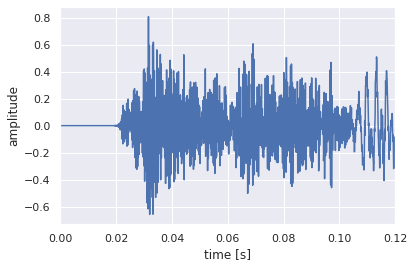

In [ ]:
# Plot nice figures using Python's "standard" matplotlib library
snd = parselmouth.Sound(audio_files[3])
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

### Plot segment spectrogram

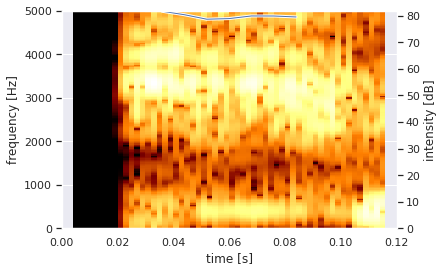

In [ ]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram.pdf")

### Plot the pitch contour

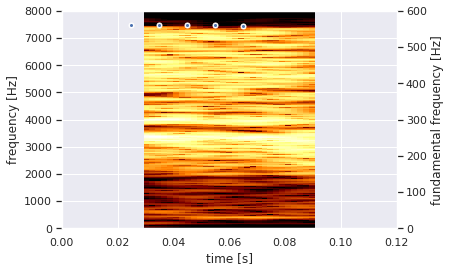

In [ ]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

pitch = snd.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram_0.03.pdf")

## Postprocess audio feature data

### Clean audio metadata

In [ ]:
audio_meta = pd.read_csv('/content/gdrive/MyDrive/EDA/audio_meta_v2.csv', low_memory=False)

audio_meta.rename(columns={'Median pitch': 'Median pitch (Hz)', 'Mean pitch': 'Mean pitch (Hz)', 'Standard deviation': 'Std pitch (Hz)', 'Minimum pitch': 'Minimum pitch (Hz)', 'Maximum pitch': 'Maximum pitch (Hz)'}, inplace=True)
audio_meta.rename(columns={'Mean period': 'Mean period (secs)', 'Standard deviation of period': 'Std period (secs)', 'Jitter (local, absolute)': 'Jitter (local, absolute, secs)', 'Degree of voice breaks': 'Degree of voice breaks (secs/secs)'}, inplace=True)
audio_meta.rename(columns={'Fraction of locally unvoiced frames': 'Fraction of locally unvoiced frames (%)', 'Jitter (local)': 'Jitter (local, %)', 'Jitter (rap)': 'Jitter (rap, %)', 'Jitter (ppq5)': 'Jitter (ppq5, %)', 'Jitter (ddp)': 'Jitter (ddp, %)', 'Shimmer (local)': 'Shimmer (local, %)', 'Shimmer (apq3)': 'Shimmer (apq3, %)', 'Shimmer (apq5)': 'Shimmer (apq5, %)', 'Shimmer (apq11)': 'Shimmer (apq11, %)', 'Shimmer (dda)': 'Shimmer (dda, %)'}, inplace=True)
audio_meta.rename(columns={'Mean harmonics-to-noise ratio': 'Mean harmonics-to-noise ratio (dB)'}, inplace=True)

audio_meta.replace('^.*undefined.*$', np.nan, regex=True, inplace=True)
audio_meta.replace([np.inf, -np.inf], np.nan, inplace=True)
audio_meta.replace(' Hz', '', regex=True, inplace=True)
audio_meta.replace(' seconds', '', regex=True, inplace=True)
audio_meta.replace('%', '', regex=True, inplace=True)
audio_meta.replace(' dB', '', regex=True, inplace=True)
audio_meta.replace(' \(\d+ / \d+\)', '', regex=True, inplace=True)
audio_meta.replace('E-(?=\d)', 'e-', regex=True, inplace=True)
audio_meta.replace(0, np.nan, inplace=True)


def get_zc_counts(zc):
    if isinstance(zc, str):
        zc_len = len(zc[1:-1].split())
        return zc_len

audio_meta["zero crossing count"] = audio_meta["zero crossing count"].apply(lambda x: get_zc_counts(x))
cols = audio_meta.columns.drop(['id', 'phone'])
audio_meta[cols] = audio_meta[cols].apply(pd.to_numeric, errors='coerce')
audio_meta = audio_meta.drop_duplicates()
audio_meta

In [ ]:
# audio_meta.to_csv('/content/gdrive/MyDrive/EDA/audio_meta_processed.csv', index=False)  

### Add categorical features to audio feature table

In [ ]:
metadata = pd.read_csv('/content/gdrive/MyDrive/EDA/audio_meta_processed.csv', low_memory=False)

In [ ]:
metadata = pd.read_csv('/content/gdrive/MyDrive/EDA/meta_balanced_v2.csv', low_memory=False)
meta_cols = metadata.drop(columns=['Unnamed: 0', 'utterance', 'utt_len', 'duration', 'phones'])
meta_cols['id'] = meta_cols["audio"].apply(lambda x: x.split('_')[-1][:-4])
meta_cols = meta_cols.drop(columns=['audio'])
meta_cols['id'] = meta_cols['id'].astype('int')
meta_cols

,gender,age,accent,id
0,male,thirties,United States English,115769
1,male,fifties,Australian English,20009601
2,male,fifties,Australian English,20009602
3,male,fifties,Australian English,20009603
4,male,fifties,Australian English,20009604
...,...,...,...,...
10306,male,fifties,"German English,Non native speaker",25891926
10307,male,fifties,"German English,Non native speaker",25891927
10308,male,fifties,"German English,Non native speaker",25891941
10309,male,fifties,"German English,Non native speaker",25891942


In [ ]:
df = pd.merge(meta_cols, audio_meta, on='id')
df

,gender,age,accent,id,phone,duration,peak amplitude,rms,intensity,f1 mean,f1 std,f2 mean,f2 std,f3 mean,f3 std,f4 mean,f4 std,harmonic mean,harmonic std,percussive mean,percussive std,centroids mean,centroids std,bandwidth mean,bandwidth std,zero crossing mean,zero crossing std,zero crossing count,Median pitch (Hz),Mean pitch (Hz),Std pitch (Hz),Minimum pitch (Hz),Maximum pitch (Hz),Number of pulses,Number of periods,Mean period (secs),Std period (secs),Fraction of locally unvoiced frames (%),Number of voice breaks,Degree of voice breaks (secs/secs),"Jitter (local, %)","Jitter (local, absolute, secs)","Jitter (rap, %)","Jitter (ppq5, %)","Jitter (ddp, %)","Shimmer (local, %)","Shimmer (local, dB)","Shimmer (apq3, %)","Shimmer (apq5, %)","Shimmer (apq11, %)","Shimmer (dda, %)",Mean autocorrelation,Mean noise-to-harmonics ratio,Mean harmonics-to-noise ratio (dB),f0 mean,f0 std
0,male,thirties,United States English,115769,[SIL],2.050023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,male,thirties,United States English,115769,ɛ,0.110023,7291.0,2164.0,-23.603854,295.653071,29.673696,1783.448433,90.194164,2115.138353,86.140727,3466.523169,117.393723,-0.000040,0.063176,-0.000021,0.008667,786.196345,103.594030,1218.813139,157.034045,0.066406,0.042417,5.0,132.073,131.731,3.038,126.118,135.101,12.0,11.0,0.007596,0.000155,12.500,NaN,0.0,1.023,0.000078,0.425,0.588,1.275,7.987,0.838,1.378,2.804,NaN,4.133,0.881341,0.253789,13.353,131.731091,2.841875
2,male,thirties,United States English,115769,v,0.120000,6766.0,1676.0,-25.823518,827.888704,534.797327,1879.029247,291.863011,2673.699063,573.943743,3908.209913,476.965113,-0.000020,0.044517,-0.000353,0.011627,1467.538608,231.841205,1902.114411,167.252540,0.097575,0.064165,6.0,128.816,129.076,0.847,128.411,130.243,7.0,6.0,0.007687,0.000215,50.000,NaN,0.0,2.119,0.000163,1.053,1.600,3.159,29.858,2.234,5.327,11.579,NaN,15.981,0.880819,0.147039,9.589,64.538155,64.540241
3,male,thirties,United States English,115769,ɝ,0.040000,4758.0,992.0,-30.378765,337.291177,NaN,2072.378700,NaN,2805.832137,NaN,3680.702509,NaN,-0.000029,0.001897,-0.000293,0.028538,1264.042756,241.705147,1995.976752,211.615625,0.141602,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,100.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,male,thirties,United States English,115769,i,0.100000,5847.0,1968.0,-24.428497,324.429823,12.300406,1510.492186,364.504779,2179.243860,78.290919,3625.578187,79.378090,-0.000334,0.055620,-0.000059,0.010076,570.068314,73.589731,993.188342,58.850805,0.054883,0.028746,5.0,119.065,118.467,2.312,114.534,120.642,10.0,9.0,0.008462,0.000242,0.000,NaN,0.0,1.225,0.000104,0.476,0.128,1.427,9.782,0.905,4.720,4.680,NaN,14.159,0.887858,0.198931,12.914,118.467393,2.140938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488716,male,fifties,"German English,Non native speaker",25891943,l,0.050023,3.0,NaN,NaN,1078.088818,NaN,2008.916233,NaN,2893.545556,NaN,3561.953643,NaN,NaN,NaN,NaN,NaN,3706.569581,219.464531,2210.537814,68.075944,0.272949,0.006905,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,100.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488717,male,fifties,"German English,Non native speaker",25891943,eɪ,0.170023,1113.0,337.0,-39.756401,513.279368,313.590527,1351.057886,174.448194,2493.375280,275.517779,3432.468898,759.612975,-0.000009,0.008820,0.000048,0.002812,1276.959863,1074.520642,1267.457950,614.946267,0.107971,0.089859,8.0,79.552,79.092,0.860,77.314,79.909,8.0,7.0,0.012663,0.000164,42.857,NaN,0.0,0.878,0.000111,0.269,0.446,0.807,13.369,1.178,3.640,12.236,NaN,10.920,0.951927,0.053144,15.330,45.195152,39.144875
488718,male,fifties,"Ger

In [ ]:
# df.to_csv('/content/gdrive/MyDrive/EDA/audio_meta_combined.csv', index=False)

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/EDA/audio_meta_combined.csv', low_memory=False)
df.shape

(488721, 56)

## Audio EDA/visulaizations


### Initial feature EDA

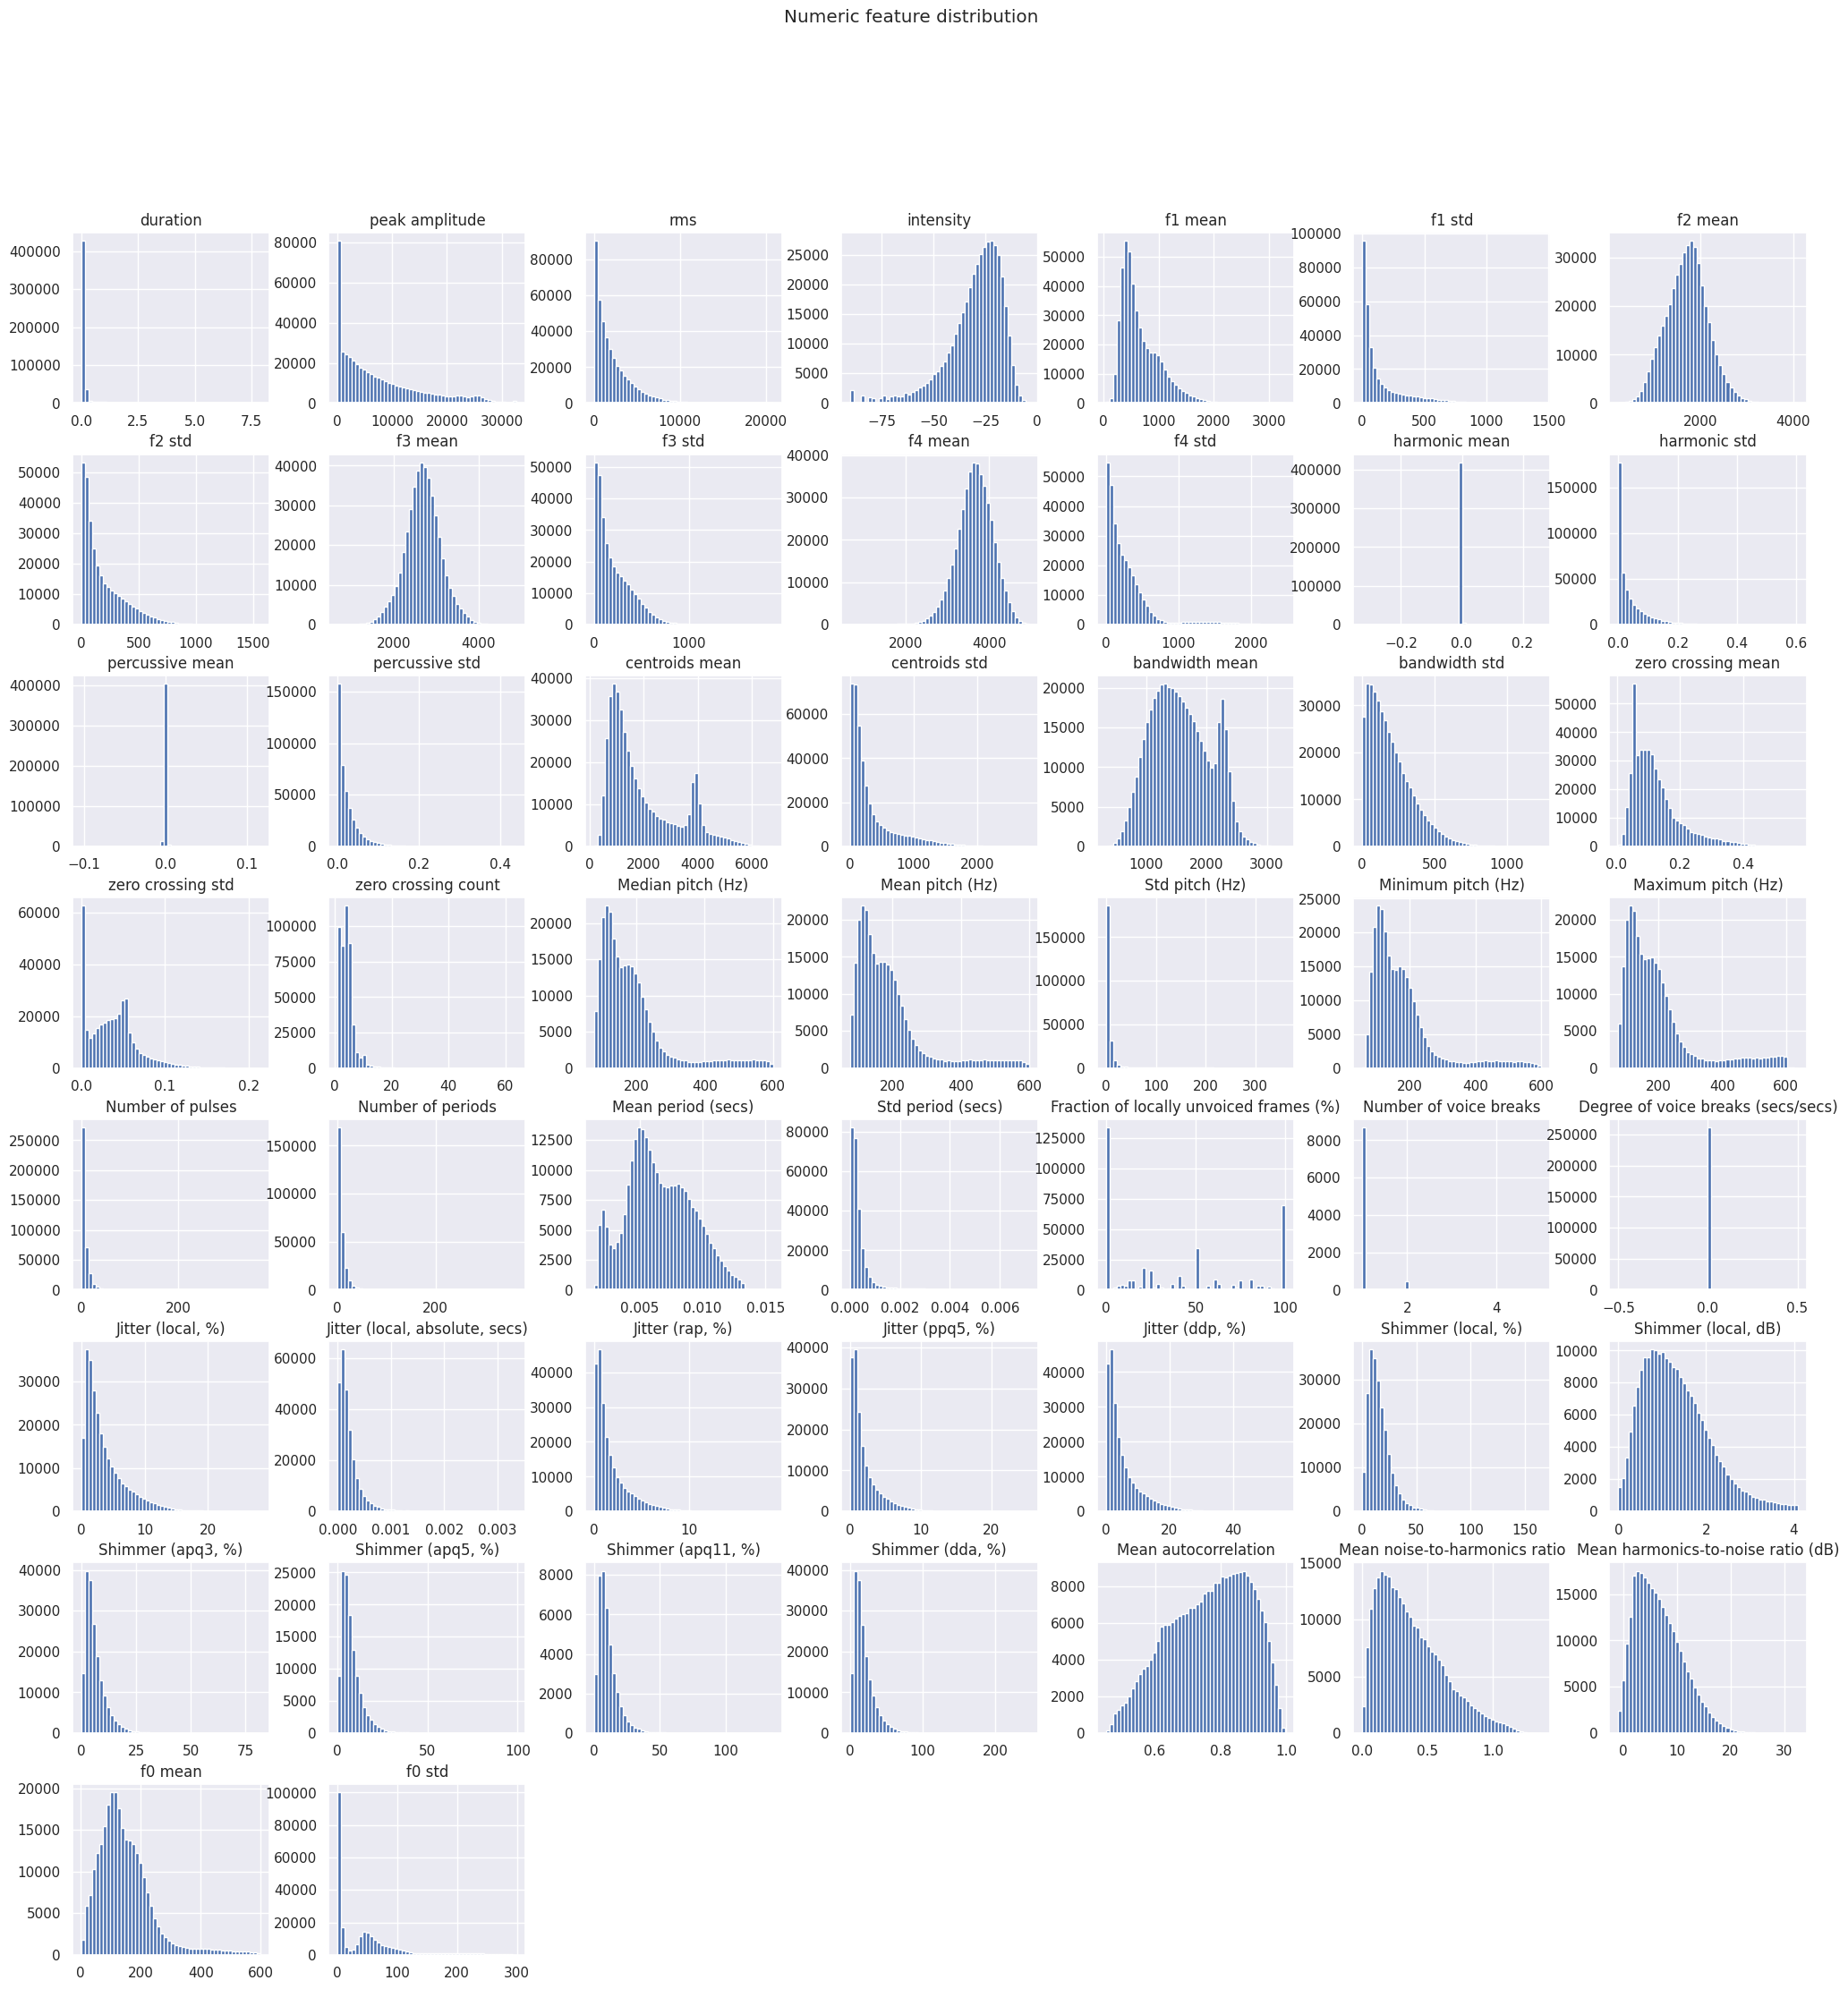

In [ ]:
df.drop(columns=['id'], inplace=True)
df.hist(figsize=[25,25], bins=50)
plt.suptitle("Numeric feature distribution")
plt.show()

Remove values with no distribution

In [ ]:
df.drop(columns=['Degree of voice breaks (secs/secs)'], inplace=True)

### Apply log transformation of right skewed data

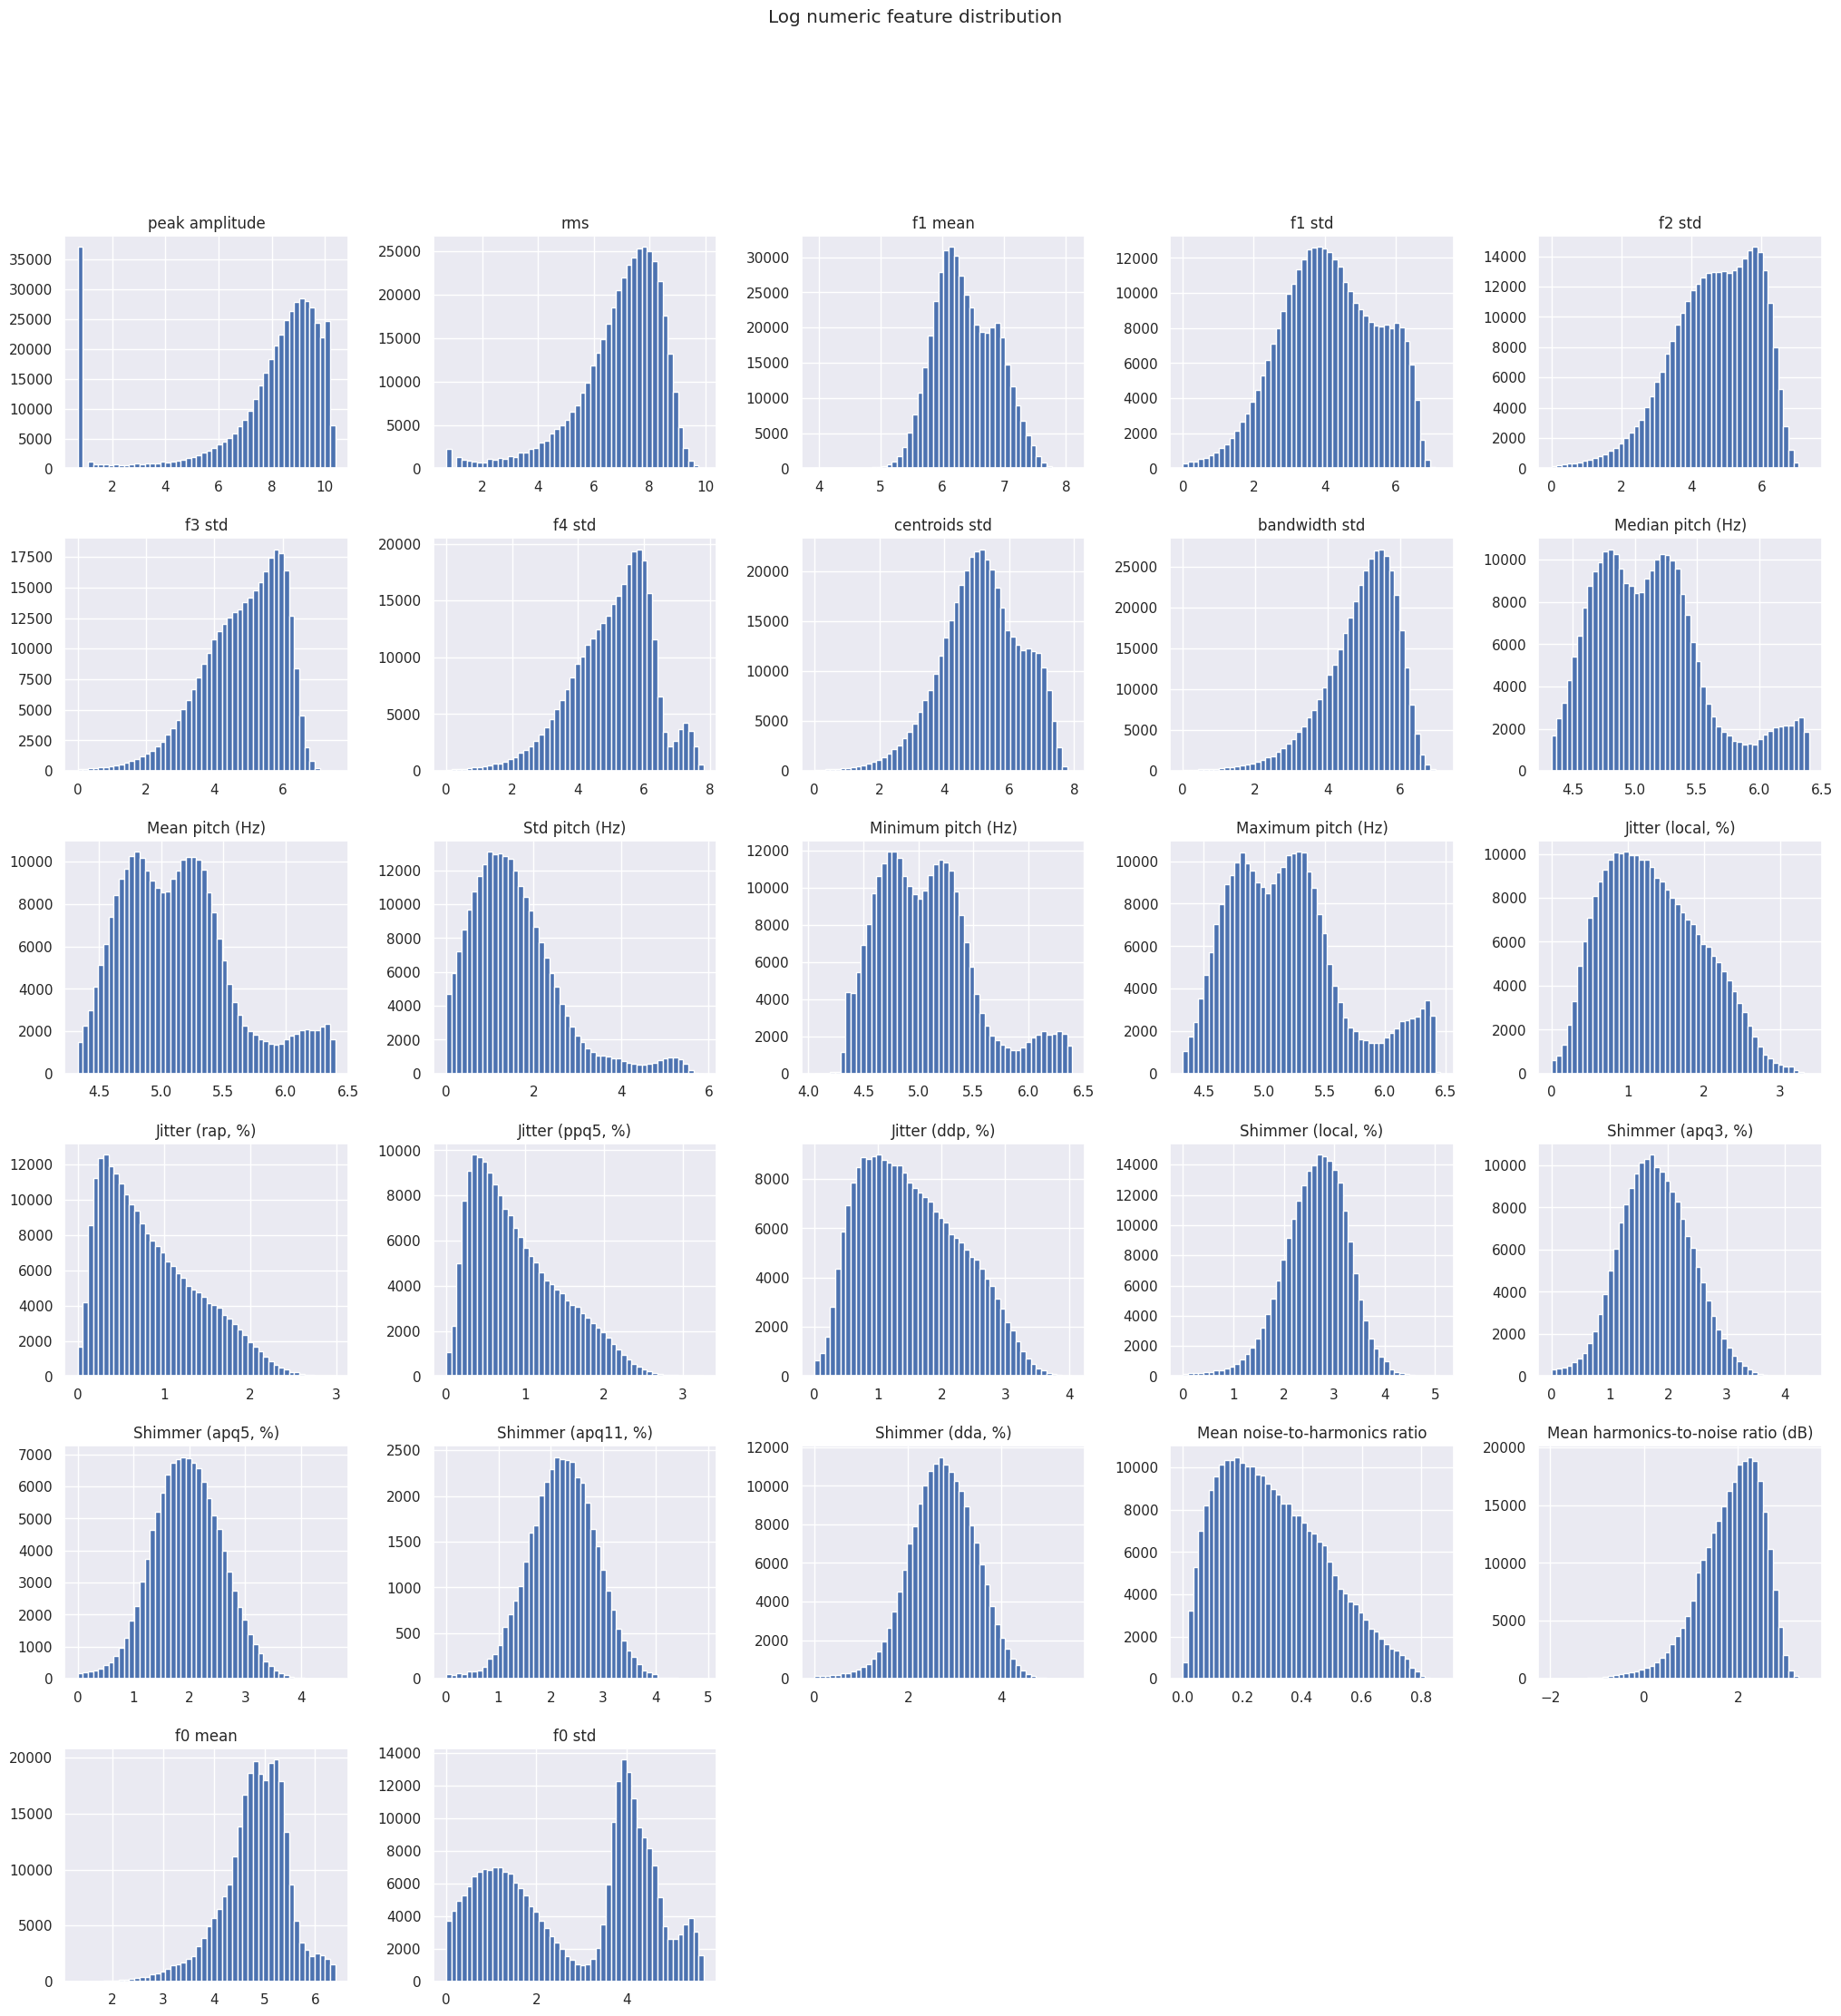

In [ ]:
# Applies log1p on features
df = df.apply(
    lambda x: np.log1p(x)
    if x.name not in [
        'id',
        'age',
        'gender',
        'phone',
        'accent',
        'duration', 
        'intensity',
        'f2 mean', 
        'f3 mean', 
        'f4 mean', 
        'harmonic mean',
        'harmonic std', 
        'percussive mean',
        'percussive std', 
        'centroids mean', 
        'bandwidth mean', 
        'zero crossing mean', 
        'zero crossing std', 
        'zero crossing count', 
        'Number of pulses', 
        'Number of periods', 
        'Mean period (secs)', 
        'Std period (secs)', 
        'Fraction of locally unvoiced frames (%)', 
        'Number of voice breaks',
        'Jitter (local, absolute, secs)',
        'Shimmer (local, dB)',
        'Mean autocorrelation'
        ]
    else x)
# Let's look at the distribution once more
df.drop(columns=[
    'id',
    'duration', 
    'intensity',
    'f2 mean', 
    'f3 mean', 
    'f4 mean', 
    'harmonic mean',
    'harmonic std',
    'percussive mean',
    'percussive std', 
    'centroids mean', 
    'bandwidth mean', 
    'zero crossing mean', 
    'zero crossing std', 
    'zero crossing count', 
    'Number of pulses', 
    'Number of periods', 
    'Mean period (secs)', 
    'Std period (secs)', 
    'Fraction of locally unvoiced frames (%)',
    'Number of voice breaks',
    'Jitter (local, absolute, secs)',
    'Shimmer (local, dB)',
    'Mean autocorrelation'
    ]).hist(figsize=[25,25], bins=50)
plt.suptitle("Log numeric feature distribution")
plt.show()

### Investigate bimodial distribution

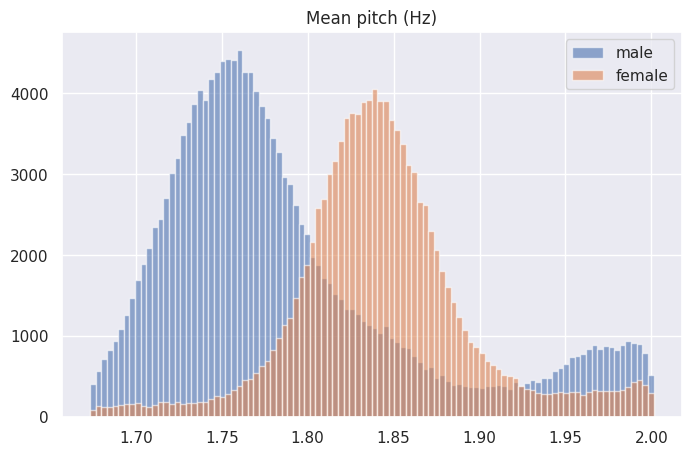

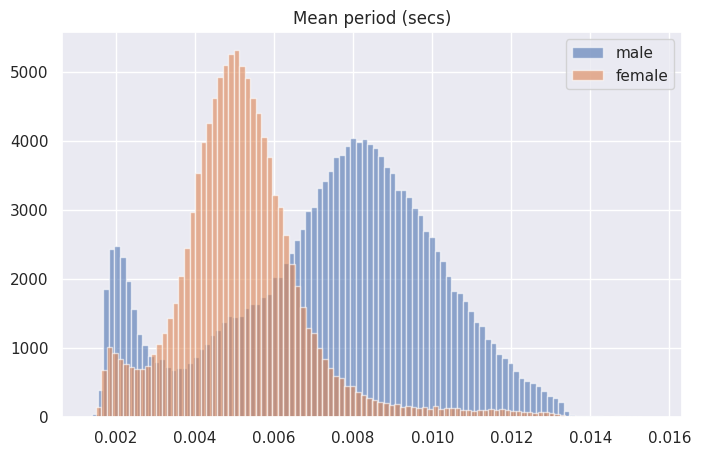

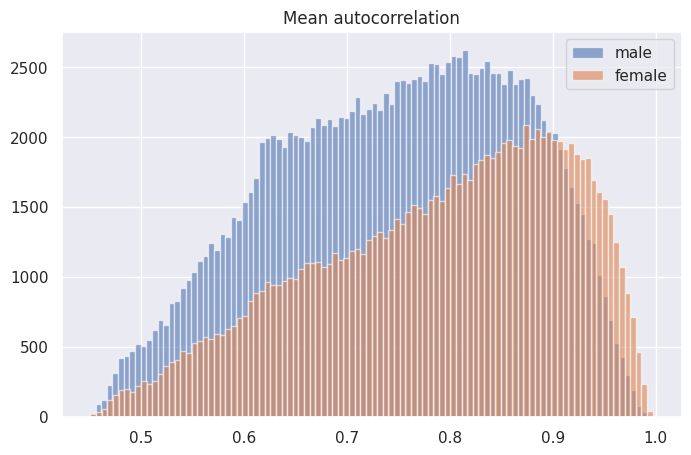

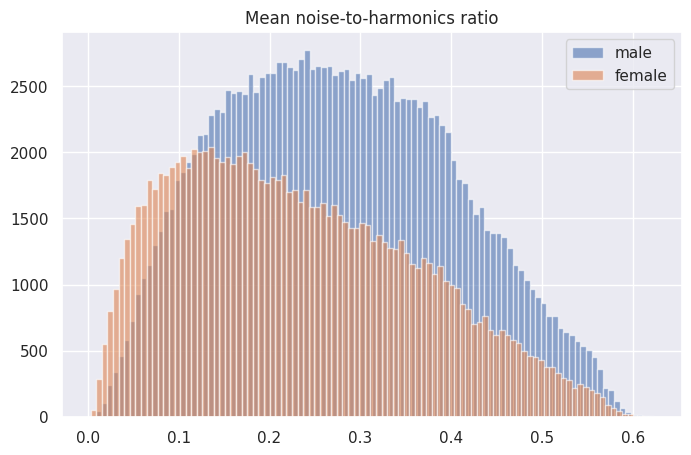

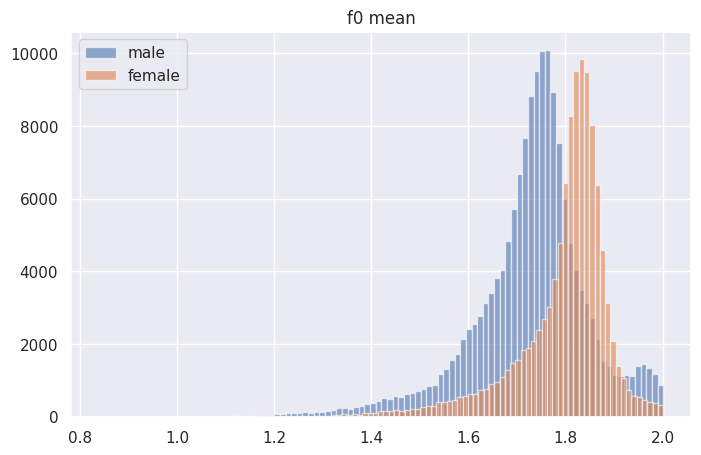

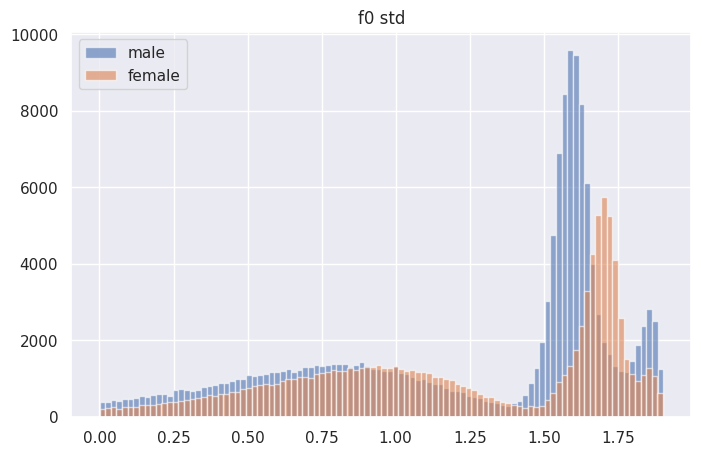

In [ ]:
for col in df.columns[4:]:
    if col in [
        'Mean pitch (Hz)',
        'Mean period (secs)',
        'Mean autocorrelation',
        'Mean noise-to-harmonics ratio',
        'f0 mean',
        'f0 std'
        ]:
        for g in df.gender.unique():
            df[df["gender"].eq(g)][col].hist(
                bins=100, figsize=(8, 5), label=g, alpha=0.6)
        plt.title(col)
        plt.legend()
        plt.show();

### Remove outliers

In [ ]:
from scipy.stats import zscore

# Only select columns with numbers from the dataframe
df_num = df.select_dtypes(np.number)

# Apply zscore to all numerical features
df_num = df_num.apply(zscore)

# Identify all samples that are below a specific z-value
z_thresh = 3
mask = np.sum(df_num.abs() > z_thresh, axis=1).eq(0)

# Only keep the values in the mask
df = df[mask]
df.shape

(475779, 55)

In [ ]:
df.to_csv('/content/gdrive/MyDrive/EDA/audio_meta_preprocessed.csv', index=False)

##Feature class EDA/Visualization

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/EDA/audio_meta_preprocessed.csv', low_memory=False)
df.drop('id', axis=1, inplace=True)
df.shape

(475779, 54)

In [ ]:
def box_plot(category):
    for col in df.columns[4:]:
        try:
            plt.figure(figsize=[14,9])
            sns.boxplot(x=category,y=col,data=df)
            plt.title(f"{col} of {category}")
            plt.show()
        except:
            continue

In [ ]:
def group_plots(category1, category2):
    for col in df.columns[4:]:
        try:
            df.groupby([category1, category2])[col].mean().unstack().plot(kind="bar", figsize=[60,21], width=.75)
            plt.title(f"{col} of {category1} for each {category2}")
            plt.ylabel(col)
            plt.xlabel(category1)
            plt.show()

            gender_col = pd.pivot_table(data=df,index=category1,columns=category2,values=col,aggfunc='mean')
            plt.figure(figsize=[4,12])
            sns.heatmap(gender_col, annot=True, linewidth=.5)
            plt.title(f"{col} of {category1} by {category2}")
            plt.show()
        except:
            continue

In [ ]:
df.groupby('phone').mean()

40

In [ ]:
box_plot('phone')

In [ ]:
df.groupby(['gender']).count()

In [ ]:
df.groupby('gender').mean()

In [ ]:
box_plot('gender')

In [ ]:
df.groupby(['phone', 'gender']).count()

In [ ]:
df.groupby(['phone', 'gender']).mean()

In [ ]:
group_plots('phone', 'gender')

In [ ]:
df.groupby(['age']).count()

In [ ]:
df.groupby('age').mean()

In [ ]:
box_plot('age')

In [ ]:
df.groupby(['phone', 'age']).count()

In [ ]:
df.groupby(['phone', 'age']).mean()

In [ ]:
group_plots('phone', 'age')

In [ ]:
df.groupby(['accent']).count()

In [ ]:
df.groupby('accent').mean()

In [ ]:
box_plot('accent')

In [ ]:
df.groupby(['phone', 'accent']).count()

In [ ]:
df.groupby(['phone', 'accent']).mean()

In [ ]:
group_plots('phone', 'accent')

In [ ]:
df.groupby(['accent', 'gender']).count()

In [ ]:
df.groupby(['accent', 'gender']).mean()

In [ ]:
group_plots('accent', 'gender')

In [ ]:
df.groupby(['accent', 'age']).count()

In [ ]:
df.groupby(['accent', 'age']).mean()

In [ ]:
group_plots('accent', 'age')

In [ ]:
df.groupby(['gender', 'age']).count()

In [ ]:
df.groupby(['gender', 'age']).mean()

In [ ]:
group_plots('gender', 'age')

## Significance testing

####Assumption checks/ Preamble.

After performing EDA, significance testing is performed to identify within and between category relationships/differences. Testing incuded one and two way ANOVA and Pairwise testing.

There are 50 features to be tested and 4 categories. Testing is done between more coarse pair testing to more finegrained. Some categories were combined to perform finegrained testing. 

Initially features were assumption checked, for example for normality of distribution and equal/similar variance between groups (homoscedasticity). Most features returned False for this assumption check. As a results modified pair testing is performed, using welch's and gameshowell's adjustments.

ANOVA one-way and two-way tests are performed on the different configurations as a first pass to identify the features that are independent or dependent. Since our classes are imbalanced type 3 method for estimating the sum of squares.

Pair testing is done using family wise error and nore specifically Holm–Bonferroni method. Holm's is used to address the problem of multiplicity that multi class comparisons can introduce, specifically in the form of type 1 error false positives. Generally Holm's is less biased and will be more forgiving to categories with less class respresentation.

Effectsize is controlled for using Hedge's G, since our data is imbalanced, Hedge's G help's by correcting for bias. Hedge's G effectsize threshold of 0.2 and above is used to filter for more meaningful effects of significant differences.

The ANOVA tests showed that the majority of the classes were independent between classes/groups. As a result a more finetuned series of pairwise tests were performed on the combinations and only the findings of these tests will be presented in this report.

####Test groups.

Various configurations of category pairs, both within and between, are tested with each feature seperately. Initially classes within each category is pairwise tested. For examples, with the gender category, the male and female classes are pair tested. Similar for age groups and accent groups.

Following this tests are done between phone category - the dependent variable, and age, gender, and accent respectively. When these tests indicated the interaction of other categories in the results, some groups were combined (e.g. gender-age, gender-accent) and then tested against the phone category.

In [ ]:
df_ = df.rename(columns=lambda x: x.replace(',', '').replace(')', '').replace('(', '').replace(':', ''))

In [ ]:
def subsample_features(metadata):

    gender_n = 500
    age_n = 143
    accent_n = 1000
    phone_n = 40000
    feats = {}
    f_list = []

    for index, row in tqdm(metadata.iterrows()):
        if row['phone'] in feats:
            feats[row['phone']]['count'] += 1
        if row['phone'] in feats:
            feats[row['phone']]['count'] += 1
        else:
            feats[row['phone']] = {
                'count': 0,
                'male': 0,
                'female': 0,
                'teens': 0,
                'twenties': 0,
                'thirties': 0,
                'fourties': 0,
                'fifties': 0,
                'sixties': 0,
                'seventies': 0,
                'United States English': 0,
                'Australian English': 0,
                'England English': 0,
                'Irish English': 0,
                'Canadian English': 0,
                'India and South Asia (India, Pakistan, Sri Lanka)': 0,
                'Southern African (South Africa, Zimbabwe, Namibia)': 0,
                'Malaysian English': 0,
                'Scottish English': 0,
                'Hong Kong English': 0,
                'Singaporean English': 0,
                'Welsh English': 0,
                'New Zealand English': 0,
                'West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad)': 0,
                'Filipino': 0,
                'German English,Non native speaker': 0
            }
        if feats[row['phone']]['count'] <= phone_n:
            feats[row['phone']][row['accent']] += 1
            if feats[row['phone']][row['accent']] <= accent_n: 
                feats[row['phone']][row['age']] += 1
                if feats[row['phone']][row['age']] <= age_n: 
                    feats[row['phone']][row['gender']] += 1
                    if feats[row['phone']][row['gender']] <= gender_n:  
                        f_list.append(row)
                    else:
                        feats[row['phone']]['count'] -= 1
                        feats[row['phone']][row['accent']] -= 1
                        feats[row['phone']][row['age']] -= 1
                        continue
                else:
                    feats[row['phone']]['count'] -= 1
                    feats[row['phone']][row['accent']] -= 1
                    continue
            else:
                feats[row['phone']]['count'] -= 1
                continue
    return f_list

In [ ]:
def add_missing(df, gender=[None], age=[None], accent=[None]):
    genders = gender
    ages = age
    accents = accent
    phones = df.phone.unique()

    combined = [genders, ages, accents, phones]
    df_part = pd.DataFrame(columns = ['gender', 'age', 'accent', 'phone'], data=list(itertools.product(*combined)))
    df_sub = df.loc[:, ['gender', 'age', 'accent', 'phone']]

    t = df_part.merge(df_sub,'inner')
    df_part = df_part.append(t).drop_duplicates(keep=False)
    df_sil_part = df_part[df_part['phone'] == '[SIL]']
    df_not_sil_part = df_part[df_part['phone'] != '[SIL]']

    df_part2 = pd.DataFrame(columns=df.columns[4:])
    dfx_sil_part = pd.concat([df_sil_part,df_part2], ignore_index=True)
    dfx_not_sil_part = pd.concat([df_not_sil_part,df_part2], ignore_index=True)

    df_sil = df[df['phone'] == '[SIL]']
    df_not_sil = df[df['phone'] != '[SIL]']

    dfx_sil = pd.concat([df_sil_part, df_sil])
    dfx_sil['duration'] = dfx_sil['duration'].fillna(dfx_sil['duration'].mean(), limit=dfx_sil_part.shape[0])

    dfx_not_sil = pd.concat([dfx_not_sil_part, df_not_sil], ignore_index=True)
    for col in dfx_not_sil.columns[27:]:
        dfx_not_sil[col] = dfx_not_sil[col].fillna(dfx_not_sil[col].mean(), limit=dfx_not_sil_part.shape[0])
    df3 = pd.concat([dfx_not_sil, dfx_sil], ignore_index=True)
    df3.insert(4, "gender_accent", df3.gender + '-' + df3.accent)
    # df3.insert(5, "age_accent", df3.age + '-' + df3.accent)
    # df3.insert(6, "gender_age_accent", df3.gender + '-' + df3.age + '-' + df3.accent)
    return df3

In [ ]:
def fill_values(df):
    cols = ['Shimmer (apq11, %)', 
            'Number of voice breaks', 
            'Shimmer (apq5, %)']
    if df.columns[-1] in cols:
        col = df.columns[-1]
        df_sil = df[df['phone'] == '[SIL]']
        df_not_sil = df[df['phone'] != '[SIL]']
        df_not_sil[col] = df_not_sil[col].fillna(df_not_sil[col].mean())
        dfx = pd.concat([df_not_sil,df_sil])
        dfx.reset_index(drop=True, inplace=True)
        return dfx
    return df

In [ ]:
def one_way_anova(category):
    for col in tqdm(df.columns[4:]):
        print(col.upper())
        df2 = df.dropna(subset=[col])
        aov = pg.welch_anova(data=df2, dv=col, between=category).round(3)
        print(aov, '\n')

In [ ]:
def pairwise_test_single(category, filter=True):
    for col in tqdm(df.columns[4:]):
        df2 = df.dropna(subset=[col])
        posthocs = pg.pairwise_gameshowell(data=df2, dv=col, between=category).round(3)
        posthocs = posthocs[posthocs['pval'] <= 0.05]
        if filter:
            posthocs = posthocs[((posthocs['hedges'] > 0) & (posthocs['hedges'] >= 0.1)) | ((posthocs['hedges'] < 0) & (posthocs['hedges'] <= -0.1))]
        if not posthocs.empty:
            print(col.upper())
            pg.print_table(posthocs)

In [ ]:
def two_way_anova(category1, category2):
    for col in tqdm(df_.columns[4:]):
        print(col.upper())
        df2 = df_.dropna(subset=[col])
        aov = df2.anova(dv=col, detailed=False, between=[category1, category2], ss_type=3).round(3)
        print(aov, '\n')

In [ ]:
def pairwise_test_multi(category1, category2, df, index, threshold, alt='two-sided', fill=False, print_res=False):
    df_pair_list = []
    for col in tqdm(df.columns[index:]):
        print(col)
        df2 = df.loc[:, [category1,category2,col]]
        # if index >= 28 <= 53 and category2 == 'gender_accent':
        #     # df2 = df2[df2['gender_accent'] != 'male-Welsh English']
        #     # print(df2.shape)
        #     df2.loc[df2['gender_accent'] == 'male-Welsh English'] = df2.loc[(df2['gender_accent'] == 'male-Welsh English') & (df2['phone'] != '[SIL]')].fillna(df2[col].mean())
        if fill:
            df2 = fill_values(df2)
        df2 = df2[df2[col].notna()]
        posthocs = pg.pairwise_tests(dv=col, between=[category1, category2], data=df2,
                                     padjust='holm', alpha=0.05, alternative=alt, correction=True).round(3)
        posthocs = posthocs[posthocs['p-corr'] <= 0.05]
        if alt == 'two-sided':
            posthocs = posthocs[((posthocs['hedges'] > 0) & (posthocs['hedges'] >= threshold)) | ((posthocs['hedges'] < 0) & (posthocs['hedges'] <= -threshold))]   
        elif alt == 'greater':
            posthocs = posthocs[posthocs['hedges'] >= threshold]
        else:
            posthocs = posthocs[posthocs['hedges'] <= threshold]
        posthocs = posthocs[posthocs['Contrast'] == f'{category1} * {category2}']
        posthocs = posthocs.drop(['Contrast', 'Paired', 'Parametric', 'p-unc', 'p-adjust', 'BF10'], axis=1)
        if not posthocs.empty:
            posthocs.insert(0, 'Feature', col)
            df_pair_list.append(posthocs)
            if print_res:
                print(df.columns.get_loc(col), col.upper())
                print(df2.shape)
                pg.print_table(posthocs)
        # index+=1
        # print(index)
    res_df = pd.concat(df_pair_list, ignore_index=True)
    res_df.to_csv(f'/content/gdrive/MyDrive/EDA/{category1}_{category2}_pair_test_results_v2.csv', index=False)

Gender

In [ ]:
one_way_anova('gender')

In [ ]:
pairwise_test_single('gender', filter=True)

####Gender (within group pair test)
The results indicate that many feature values are independent between male and female. However when adjusting for effectsize (0.1 ) that the main features that genders differ are:

- F2 std (female higher)
- F3 mean and std (female higher)
- F4 mean and std (female higher)
- Harmonic std (female higher)
- Percussive std (male higher)
- Centroids std (female higher)
- Bandwidth std (female higher)
- Pitch median, mean, minimum, maximum and std (female higher)
- Number of pulses (female higher)
- Number of periods (female higher)
- Period mean and std (male higher)
- Jitter local absolute/PPQ5 (male higher)
- Mean autocorrelation (female higher)
- Mean noise-to-harmonics ratio (male higher)
- Mean harmonics-to-noise ratio (female higher)
- F0 mean (female higher)

These values indicate differences in vowel articulation (F2, F3, F4), consonantal sounds (percussive), tone/timbre (centroids, number of pulses), frequency range (bandwidth, pitch), periodicity and acoustic source features (harmonics, period, f0, jitter, autocorrelation), filter features (noise-to-harmonics, harmonics-to-noise, formant values). These are generally understood differences of male and female features. 



In [ ]:
two_way_anova('phone', 'gender')

In [ ]:
pairwise_test_multi('phone', 'gender', df, index=5, threshold=0.2)

#####Phone/Gender

Pairwise testing is done with phone as dependent variable and within gender classes as independent variables. An effectsize of 2.0 is applied to filter for only meaningful results. In 70% of the features, females had a higher value than males (similar to what was observed in the initial test). 

**Features**

All of the features listed in the the within gender pairwise test are well represented, with the top n counts of features in the results all populated with most of the features from the previous test.

```
Minimum pitch (Hz) 	39 	5.6%
Mean period (secs) 	39 	5.6%
Mean pitch (Hz) 	39 	5.6%
Median pitch (Hz) 	39 	5.6%
Maximum pitch (Hz) 	39 	5.6%
f0 mean 	38 	5.5%
Mean noise-to-harmonics ratio 	37 	5.3%
Jitter (local, absolute, secs) 	37 	5.3%
Mean autocorrelation 	36 	5.2%
Mean harmonics-to-noise ratio (dB) 	34 	4.9%
Number of pulses 	32 	4.6%
```

**Phones**

The results show that the top n phones that have the biggest disparity of feature values between males and females are:

```
j 	29 	4.2%
aɪ 	27 	3.9%
aʊ 	25 	3.6%
eɪ 	25 	3.6%
ɛ 	24 	3.5%
dʒ 	23 	3.3%
oʊ 	22 	3.2%
ʃ 	22 	3.2%
ɔ 	21 	3.0%
ɑ 	20 	2.9%
h 	20 	2.9%
```

Nearly half are diphthongs e.g. aɪ or the glide /j/ that has diphthong like quality. Most are vowels in general. The rest are frication type sounds such as /h/, /ʃ/, and /dʒ/. Vowels are also key indicators of accent differences and these results may be interacting with this underlying aspect.

In [ ]:
df_pg = pd.read_csv('/content/gdrive/MyDrive/EDA/phone_gender_pair_test_results.csv', low_memory=False)
df_pg

In [ ]:
get_counts_perc(df_pg, 'Feature')

In [ ]:
get_counts_perc(df_pg, 'phone')

In [ ]:
get_counts_perc(df_pg, 'A')

In [ ]:
get_counts_perc(df_pg, 'B')

In [ ]:
get_group_counts_perc(df_pg, 'Feature', 'phone')

In [ ]:
get_group_counts_perc(df_pg, 'Feature', 'A')

In [ ]:
get_group_counts_perc(df_pg, 'Feature', 'B')

In [ ]:
get_group_counts_perc(df_pg, 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pg, 'phone', 'B')

In [ ]:
get_group_counts_perc(df_pg, 'Feature', 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pg, 'Feature', 'phone', 'B')

In [ ]:
df_pg_g = df_pg[df_pg['hedges'] > 0]
df_pg_l = df_pg[df_pg['hedges'] < 0]

In [ ]:
get_counts_perc(df_pg_g, 'Feature')

In [ ]:
get_counts_perc(df_pg_l, 'Feature')

In [ ]:
get_counts_perc(df_pg_g, 'phone')

In [ ]:
get_counts_perc(df_pg_l, 'phone')

In [ ]:
get_counts_perc(df_pg_g, 'A')

In [ ]:
get_counts_perc(df_pg_g, 'B')

In [ ]:
get_counts_perc(df_pg_l, 'A')

In [ ]:
get_counts_perc(df_pg_l, 'B')

In [ ]:
get_group_counts_perc(df_pg_g, 'Feature', 'phone')

In [ ]:
get_group_counts_perc(df_pg_l, 'Feature', 'phone')

In [ ]:
get_group_counts_perc(df_pg_g, 'Feature', 'A')

In [ ]:
get_group_counts_perc(df_pg_g, 'Feature', 'B')

In [ ]:
get_group_counts_perc(df_pg_l, 'Feature', 'A')

In [ ]:
get_group_counts_perc(df_pg_l, 'Feature', 'B')

In [ ]:
get_group_counts_perc(df_pg_g, 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pg_g, 'phone', 'B')

In [ ]:
get_group_counts_perc(df_pg_l, 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pg_l, 'phone', 'B')

In [ ]:
get_group_counts_perc(df_pg_g, 'Feature', 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pg_g, 'Feature', 'phone', 'B')

In [ ]:
get_group_counts_perc(df_pg_l, 'Feature', 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pg_l, 'Feature', 'phone', 'B')

Age

In [ ]:
one_way_anova('age')

In [ ]:
pairwise_test_single('age')

####Age (within group pair test)
The results indicate that many feature values are independent between age classes. However when adjusting for effectsize (0.1 ) that the main features that ages differ are:

- Peak Amplitude
- RMS (power)
- Intensity
- F1 mean
- F2 mean and std
- F3 mean and std
- F4 mean and std
- Harmonic std
- Percussive std
- Centroids mean and std
- Bandwidth mean and std
- Zero crossing count
- Pitch median, mean, minimum, maximum
- Number of pulses
- Number of periods
- Mean and std period
- Fraction on locally unvoiced frames
- Number of voice breaks
- Jitter local, locale absolute, ppq5, ddp
- shimmer apq5, apq3, apq11, dda
- Mean autocorrelation
- Mean noise-to-harmonics ratio
- Mean harmonics-to-noise ratio
- F0 mean

In additon to the value differences found in between gender testing. *Apmlitude, power, intensity, means of centroids* and *bandwidth, zero crossing count, fraction of locally unvoiced frames, number of voice breaks, addtional jitter values,* and *shimmer values*.

Based on what was observed for gender, vowels are typically where different classes of categories differ. With age these vowel based differences appear to continue, but with addtional features also at play. Features such as energy, power and zero crossing, fraction of locally unvoiced frames, number of voice breaks, and jitter are related to voicing in speech and since vowels are voiced, those features play significant roles in their production.

Amplitude, centroids, bandwidth, and shimmer are key aspects in defining the spectral features, which is an important feature of intellibility.

Features such as jitter and shimmer may play a significant role in differentiating older and younger speakers. Jitter is the measure of the cycle-to-cycle variations of the fundamental glottal period and shimmer is the cycle-to-cycle variations of the fundamental glottal period amplitudes. It is reasonable to assume that there would likely be more irregularity in older speakers with respect to these features in particular.

In [ ]:
two_way_anova('phone', 'age')

In [ ]:
pairwise_test_multi('phone', 'age', df, index=4, threshold=0.2, fill=True)

100%|██████████| 50/50 [07:44<00:00,  9.28s/it]


#####Phone/Age

**Features**

Just as with gender, all of the features listed in the within age pairwise test are well represented, with the top n counts of features in the results all populated with most of the features from the previous test. However, with age we see voicing and spectral related feature difference counts in the top n behind the pitch value presence. We can infer that these features are important differences between age groups. 

Since we saw that pitch is a key feature in differentiating gender, and pitch still features highly here, we can infer that there is a gender and age based differentiation between the groups. Moreover that gender differences are still key indicators.

```
Mean period (secs) 	329 	6.7%
Median pitch (Hz) 	266 	5.4%
Mean pitch (Hz) 	263 	5.3%
f0 mean 	263 	5.3%
Minimum pitch (Hz) 	249 	5.1%
Maximum pitch (Hz) 	248 	5.0%
Fraction of locally unvoiced frames (%) 	226 	4.6%
intensity 	224 	4.6%
rms 	205 	4.2%
peak amplitude 	201 	4.1%
```

**Phones**

The results show that the top n phones that have the biggest disparity of feature values between age ranges are:

```
eɪ 	293 	6.0%
aɪ 	234 	4.8%
i 	218 	4.4%
ɛ 	209 	4.3%
ɔ 	203 	4.1%
w 	203 	4.1%
ɑ 	201 	4.1%
oʊ 	200 	4.1%
m 	196 	4.0%
æ 	190 	3.9%
```

Like with the gender test diphthongs feature significantly and similarly most are vowels in general. The remaining are from similar category of sounds, sonorants, that vowels, approximants (/w/) and nasals (/m/) belong.

**Age group**

There is a clear age group based differentiation of features:

```
seventies 	1726 	35.1%
fifties 	1129 	23.0%
sixties 	972 	19.8%
fourties 	923 	18.8%
teens 	155 	3.2%
thirties 	12 	0.2%
```
In particular, older age groups are more frequently found as a contrasting feature class when measuring acoustic feature value differences. And looking at the classes that the ones above tend to contrast with we see the age class dynamic more clearly as the yoounger age groups are more likely more strongly differentiated with the older groups:

```
thirties 	1276 	26.0%
teens 	1152 	23.4%
twenties 	1001 	20.4%
seventies 	731 	14.9%
sixties 	538 	10.9%
fourties 	219 	4.5%
```
However, as seen in the initial metadata EDA, the older age groups are overrepresented by the female gender. Therefore this may still be indicated gender based differences, something we will take a look at.

In [ ]:
df_pa = pd.read_csv('/content/gdrive/MyDrive/EDA/phone_age_pair_test_results.csv', low_memory=False)
df_pa

In [ ]:
get_counts_perc(df_pa, 'Feature')

In [ ]:
get_counts_perc(df_pa, 'phone')

In [ ]:
get_counts_perc(df_pa, 'A')

In [ ]:
get_counts_perc(df_pa, 'B')

In [ ]:
get_group_counts_perc(df_pa, 'Feature', 'phone')

In [ ]:
get_group_counts_perc(df_pa, 'Feature', 'A')

In [ ]:
get_group_counts_perc(df_pa, 'Feature', 'B')

In [ ]:
get_group_counts_perc(df_pa, 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pa, 'Feature', 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pa, 'Feature', 'phone', 'B')

In [ ]:
df_pa_g = df_pa[df_pa['hedges'] > 0]
df_pa_l = df_pa[df_pa['hedges'] < 0]

In [ ]:
get_counts_perc(df_pa_g, 'Feature')

In [ ]:
get_counts_perc(df_pa_l, 'Feature')

In [ ]:
get_counts_perc(df_pa_g, 'phone')

In [ ]:
get_counts_perc(df_pa_l, 'phone')

In [ ]:
get_counts_perc(df_pa_g, 'A')

In [ ]:
get_counts_perc(df_pa_l, 'A')

In [ ]:
get_counts_perc(df_pa_g, 'B')

In [ ]:
get_counts_perc(df_pa_l, 'B')

In [ ]:
get_group_counts_perc(df_pa_g, 'Feature', 'phone')

In [ ]:
get_group_counts_perc(df_pa_l, 'Feature', 'phone')

In [ ]:
get_group_counts_perc(df_pa_g, 'Feature', 'A')

In [ ]:
get_group_counts_perc(df_pa_l, 'Feature', 'A')

In [ ]:
get_group_counts_perc(df_pa_g, 'Feature', 'B')

In [ ]:
get_group_counts_perc(df_pa_l, 'Feature', 'B')

In [ ]:
get_group_counts_perc(df_pa_g, 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pa_l, 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pa_g, 'phone', 'B')

In [ ]:
get_group_counts_perc(df_pa_l, 'phone', 'B')

In [ ]:
get_group_counts_perc(df_pa_g, 'Feature', 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pa_l, 'Feature', 'phone', 'A')

In [ ]:
get_group_counts_perc(df_pa_g, 'Feature', 'phone', 'B')

In [ ]:
get_group_counts_perc(df_pa_l, 'Feature', 'phone', 'B')

Accent

In [ ]:
one_way_anova('accent')

In [ ]:
pairwise_test_single('accent')

####Accent (within group pair test)
The main features that accents differ are (0.1 effectize):

- Duration
- Amplitude
- RMS
- Intensity
- F1 mean and std
- F2 mean and std
- F3 mean and std
- F4 mean and std
- Harmonic std
- Percussive std
- Centroids mean and std
- Bandwidth mean and std
- Zero crossing mean, std, and count
- Pitch median, mean, minimum, maximum and std
- Number of pulses
- Number of periods
- Period mean and std
- Fraction of locally unvoiced frames
- Jitter local, local absolute, rap, ppq5, ddp
- shimmer local, apq5, apq3, apq11, dda
- Mean autocorrelation
- Mean noise-to-harmonics ratio
- Mean harmonics-to-noise ratio
- F0 mean and std

There are many overlapping features with the other categories, but with some addtional mean, std, and sub feature values. These sub feature values may indicate the differences between dialects. 

Duration is found to be a meaningful differentiable feature for accents, but not with the other categories. Since duration is a prosodic feature, these differences may be carry overs from L1 prosodic behaviour.

Also, the number of voice breaks feature is not meaningful here and with gender, but was meanignful with the age group.



In [ ]:
two_way_anova('phone', 'accent')

In [ ]:
pairwise_test_multi('phone', 'accent', df, index=4, threshold=0.2, fill=True)

100%|██████████| 50/50 [23:52<00:00, 28.64s/it]


#####Phone/Accent

**Features**

All of the features listed in the within age pairwise test are well represented, with the top n counts of features in the results all populated with most of the features from the previous test. However, the most differentiable features for accents are vastly different to the previous groups:

```
harmonic std 	974 	4.9%
Mean period (secs) 	839 	4.3%
Number of pulses 	830 	4.2%
bandwidth mean 	816 	4.1%
f3 mean 	804 	4.1%
duration 	790 	4.0%
zero crossing count 	770 	3.9%
intensity 	767 	3.9%
percussive std 	762 	3.9%
f2 mean 	756 	3.8%
```
Broadly speaking, these features seem to indicate difference in voiced sonorant realization, something particularly indicated by the presence of formant values (f2 and f3 mean).

**Phones**

The results show that the top n phones that have the biggest disparity of feature values between accents are:

```
ɪ 	1179 	6.0%
n 	1169 	5.9%
l 	1138 	5.8%
ɹ 	1123 	5.7%
ʌ 	1094 	5.6%
ɝ 	999 	5.1%
i 	967 	4.9%
s 	953 	4.8%
m 	919 	4.7%
t 	818 	4.2%
```

Unlike with the previous categories, diphthongs do not feature in the top n of differentiable phones. Instead the sounds are mostly broadly sonorant, with nearly half being vowels. There is also /s/ and /t/. /t/ generally has different allophonic realizations between accents, particularly intervocalically or between voiced sounds.

**Accent group**

Below are top n accents groups ranked by diffrentiated features:

```
German English,Non native speaker 	3524 	17.9%
India and South Asia (India, Pakistan, Sri Lanka) 	2748 	14.0%
England English 	1907 	9.7%
Canadian English 	1904 	9.7%
Australian English 	1700 	8.6%
Hong Kong English 	1600 	8.1%
Filipino 	1516 	7.7%
Malaysian English 	1413 	7.2%
```
It is worth noting that the German group only contains male speakers, which may be skewing the differentiation. Similarly, the Indian accented data is largely females.

Below are the top n accents that are constrastive to the above accents due to the significance of the difference of feature values.

```
Singaporean English 	2572 	13.1%
West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad) 	2113 	10.7%
United States English 	1866 	9.5%
Welsh English 	1829 	9.3%
Malaysian English 	1755 	8.9%
India and South Asia (India, Pakistan, Sri Lanka) 	1473 	7.5%
New Zealand English 	1421 	7.2%
Scottish English 	1394 	7.1%
Southern African (South Africa, Zimbabwe, Namibia) 	1357 	6.9%
German English,Non native speaker 	1319 	6.7%
```


In [ ]:
df_pc = pd.read_csv('/content/gdrive/MyDrive/EDA/phone_accent_pair_test_results.csv', low_memory=False)
df_pc

In [ ]:
get_counts_perc(df_pc, 'Feature')

In [ ]:
get_counts_perc(df_pc, 'phone')

In [ ]:
get_counts_perc(df_pc, 'A')

In [ ]:
get_counts_perc(df_pc, 'B')

In [ ]:
get_group_counts_perc(df_pc, 'Feature', 'phone', n=8)

In [ ]:
get_group_counts_perc(df_pc, 'Feature', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pc, 'Feature', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pc, 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pc, 'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pc, 'Feature', 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pc, 'Feature', 'phone', 'B', n=10)

In [ ]:
df_pc_g = df_pc[df_pc['hedges'] > 0]
df_pc_l = df_pc[df_pc['hedges'] < 0]

In [ ]:
get_counts_perc(df_pc_g, 'Feature')

In [ ]:
get_counts_perc(df_pc_l, 'Feature')

In [ ]:
get_counts_perc(df_pc_g, 'phone')

In [ ]:
get_counts_perc(df_pc_l, 'phone')

In [ ]:
get_counts_perc(df_pc_g, 'A')

In [ ]:
get_counts_perc(df_pc_l, 'A')

In [ ]:
get_counts_perc(df_pc_g, 'B')

In [ ]:
get_counts_perc(df_pc_l, 'B')

In [ ]:
get_group_counts_perc(df_pc_g, 'Feature', 'phone', n=10)

In [ ]:
get_group_counts_perc(df_pc_l, 'Feature', 'phone', n=10)

In [ ]:
get_group_counts_perc(df_pc_g, 'Feature', 'A', n=5)

In [ ]:
get_group_counts_perc(df_pc_l, 'Feature', 'A', n=5)

In [ ]:
get_group_counts_perc(df_pc_g, 'Feature', 'B', n=5)

In [ ]:
get_group_counts_perc(df_pc_l, 'Feature', 'B', n=5)

In [ ]:
get_group_counts_perc(df_pc_g, 'phone', 'A', n=5)

In [ ]:
get_group_counts_perc(df_pc_l, 'phone', 'A', n=5)

In [ ]:
get_group_counts_perc(df_pc_g, 'phone', 'B', n=5)

In [ ]:
get_group_counts_perc(df_pc_l, 'phone', 'B', n=5)

In [ ]:
get_group_counts_perc(df_pc_g,'Feature', 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pc_l,'Feature', 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pc_g,'Feature', 'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pc_l,'Feature', 'phone', 'B', n=10)

### Significance testing between combined groups

In [ ]:
df2 = df.copy()
df2.insert(3, "gender_age", df.gender + '-' + df.age)
df2

In [ ]:
df2_ = df2.rename(columns=lambda x: x.replace(',', '').replace(')', '').replace('(', '').replace(':', ''))

In [ ]:
pairwise_test_multi('phone', 'gender_age', df2, index=5, threshold=0.5, fill=True)

100%|██████████| 50/50 [18:49<00:00, 22.58s/it]


#####Phone/Gender-Age

**Features**

Looking closer at at the gender-age group interaction with the pair testing results, beginning with the top n features:

```
Mean period (secs) 	1757 	12.1%
Minimum pitch (Hz) 	1590 	11.0%
Mean pitch (Hz) 	1572 	10.8%
Median pitch (Hz) 	1568 	10.8%
Maximum pitch (Hz) 	1487 	10.3%
f0 mean 	1286 	8.9%
```
From the top n data we can see that the main feature that differentiates between classes is the features that differentiate genders. This would indicate that the overriding feature for gender-age classes is the gender features and the skewed distribution of genders between age groups influenced the phone/age pair testing significantly.

**Phones**

The results show that the top n phones that have the biggest disparity of feature values between gender-age are:

```
eɪ 	758 	5.2%
aɪ 	656 	4.5%
i 	598 	4.1%
j 	598 	4.1%
ɔ 	536 	3.7%
ŋ 	514 	3.5%
w 	508 	3.5%
ɛ 	505 	3.5%
æ 	496 	3.4%
oʊ 	489 	3.4%
```

The top n phones are predominately vowels as was seen with the individual gender and age groups. However the distribution is more similar to the phone/gender pair test distribution.

**Gender-Age group**

Below are top n gender-age groups ranked by diffrentiated features:

```
female-seventies 	2501 	17.2%
female-teens 	2445 	16.9%
female-fifties 	2185 	15.1%
female-sixties 	1914 	13.2%
female-twenties 	1800 	12.4%
female-thirties 	1777 	12.3%
female-fourties 	1669 	11.5%
```
The distribution of the top n differentiable classes is slightly different to the age groups ranks. In this distribution female-teens also rank as highly differentiable. It is reasonable that the very youngest and very oldest ages have differentiable acoustic features.

Below we see the gender-age classes that are highly contrastive to the above group. It is clear that gender is a significant differentiable feature. Age appears to play less a factor for the male group than the female group.

```
male-thirties 	2137 	14.7%
male-fourties 	2135 	14.7%
male-sixties 	2120 	14.6%
male-seventies 	1910 	13.2%
male-fifties 	1901 	13.1%
male-twenties 	1766 	12.2%
male-teens 	1486 	10.2%
```

In [ ]:
df_pga = pd.read_csv('/content/gdrive/MyDrive/EDA/phone_gender_age_pair_test_results.csv', low_memory=False)
df_pga

In [ ]:
get_counts_perc(df_pga, 'Feature')

In [ ]:
get_counts_perc(df_pga, 'phone')

In [ ]:
get_counts_perc(df_pga, 'A')

In [ ]:
get_counts_perc(df_pga, 'B')

In [ ]:
get_group_counts_perc(df_pga,'Feature', 'phone', n=10)

In [ ]:
get_group_counts_perc(df_pga,'Feature', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pga,'Feature', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pga,'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pga,'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pga,'Feature', 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pga,'Feature', 'phone', 'B', n=10)

In [ ]:
df_pga_g = df_pga[df_pga['hedges'] > 0]
df_pga_l = df_pga[df_pga['hedges'] < 0]

In [ ]:
get_counts_perc(df_pga_g, 'Feature')

In [ ]:
get_counts_perc(df_pga_l, 'Feature')

In [ ]:
get_counts_perc(df_pga_g, 'phone')

In [ ]:
get_counts_perc(df_pga_l, 'phone')

In [ ]:
get_counts_perc(df_pga_g, 'A')

In [ ]:
get_counts_perc(df_pga_l, 'A')

In [ ]:
get_counts_perc(df_pga_g, 'B')

In [ ]:
get_counts_perc(df_pga_l, 'B')

In [ ]:
get_group_counts_perc(df_pga_g,'Feature', 'phone', n=10)

In [ ]:
get_group_counts_perc(df_pga_l,'Feature', 'phone', n=10)

In [ ]:
get_group_counts_perc(df_pga_g,'Feature', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pga_l,'Feature', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pga_g,'Feature', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pga_l,'Feature', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pga_g, 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pga_l, 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pga_g, 'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pga_l, 'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pga_g, 'Feature', 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pga_l, 'Feature', 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pga_g, 'Feature', 'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pga_l, 'Feature', 'phone', 'B', n=10)

In [ ]:
# Add missing values
data = {
    'gender': ['female', 'male', 'male', 'female', 'male', 'male'],
    'accent': ['West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad)',
               'Welsh English',
               'Hong Kong English',
               'Malaysian English',
               'England English',
               'Filipino'
    ],
    'phone': ['ɔɪ', 'ʒ', 'ʒ', 'ʒ', 'ʒ', 'ʒ']
}
df_part = pd.DataFrame.from_dict(data)
dfx = pd.concat([df_part, df], ignore_index=True)
print(df_part.shape[0])
for col in dfx.columns[4:]:
    dfx[col] = dfx[col].fillna(dfx[col].mean(), limit=df_part.shape[0])
dfx.insert(3, "gender_accent", dfx.gender + '-' + dfx.accent)

6


In [ ]:
pairwise_test_multi('phone', 'gender_accent', dfx, index=5, threshold=0.5, fill=True)

#####Phone/Gender-Accent

**Features**

Based on the below features, gender is overwhelming influencing the difference in values between features. This can be ssen by the presence of gender defining features vs the absence of the features found when comparing with accents alone.

```
Mean period (secs) 	7804 	11.4%
Minimum pitch (Hz) 	6496 	9.5%
Median pitch (Hz) 	6451 	9.5%
Mean pitch (Hz) 	6423 	9.4%
Maximum pitch (Hz) 	5925 	8.7%
f0 mean 	5379 	7.9%
Number of pulses 	2364 	3.5%
Number of periods 	1945 	2.9%
```

**Phones**

Similar to the features, the types of differentiable phones are also reflective of the gender class, but the top n also includes sonorants as was observed in the phone/accent results. Generally however, the distribution is skewed towards the gender features, as shown by the diphthongs and their relative frequency. 

```
eɪ 	3734 	5.5%
aɪ 	3200 	4.7%
ɛ 	3140 	4.6%
i 	3027 	4.4%
æ 	2780 	4.1%
ɝ 	2699 	4.0%
m 	2613 	3.8%
ɪ 	2530 	3.7%
l 	2510 	3.7%
w 	2479 	3.6%
ɑ 	2475 	3.6%
ɔ 	2454 	3.6%
n 	2434 	3.6%
oʊ 	2404 	3.5%
```

**Gender-Accent group**

Below are top n gender-accent classes ranked:

```
female-India and South Asia (India, Pakistan, Sri Lanka) 	10263 	15.1%
female-Malaysian English 	5656 	8.3%
female-Hong Kong English 	5166 	7.6%
female-England English 	4829 	7.1%
female-Southern African (South Africa, Zimbabwe, Namibia) 	4638 	6.8%
female-Australian English 	4601 	6.7%
female-Canadian English 	4245 	6.2%
female-Filipino 	3985 	5.8%
female-Scottish English 	3943 	5.8%
female-Welsh English 	3767 	5.5%
female-United States English 	3522 	5.2%
female-Irish English 	3382 	5.0%
female-Singaporean English 	2873 	4.2%
female-New Zealand English 	2680 	3.9%
```
Something recognised in the phone/accent results was the impact of the gender distribution of the Indian accent data. Here we see that class of data very overrepresented in the frequency ranks. We also see the absence of the german speaker class, meaning the gener based differences are more of a differentiable feature than accent. However there are still some corresponding ordering to the phone/accent data, which would indicate accent is still a significant differentiable feature.

Below we see the top n constrastive classes, which are effectively single gender type.

```
male-Irish English 	4779 	7.0%
male-Singaporean English 	4700 	6.9%
male-Scottish English 	4265 	6.3%
male-German English,Non native speaker 	4114 	6.0%
male-Canadian English 	4060 	6.0%
male-West Indies and Bermuda (Bahamas, Bermuda, Jamaica, Trinidad) 	4037 	5.9%
male-Southern African (South Africa, Zimbabwe, Namibia) 	3973 	5.8%
male-New Zealand English 	3971 	5.8%
male-Australian English 	3850 	5.6%
male-England English 	3674 	5.4%
male-Filipino 	3541 	5.2%
male-Hong Kong English 	3449 	5.1%
male-United States English 	3423 	5.0%
male-Welsh English 	3313 	4.9%
male-India and South Asia (India, Pakistan, Sri Lanka) 	3203 	4.7%
```


In [ ]:
df_pgc = pd.read_csv('/content/gdrive/MyDrive/EDA/phone_gender_accent_pair_test_results_v2.csv', low_memory=False)
df_pgc

In [ ]:
get_counts_perc(df_pgc, 'Feature')

In [ ]:
get_counts_perc(df_pgc, 'phone')

In [ ]:
get_counts_perc(df_pgc, 'A')

In [ ]:
get_counts_perc(df_pgc, 'B')

In [ ]:
get_group_counts_perc(df_pgc, 'Feature', 'phone', n=10)

In [ ]:
get_group_counts_perc(df_pgc, 'Feature', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pgc, 'Feature', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pgc, 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pgc, 'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pgc, 'Feature', 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pgc, 'Feature', 'phone', 'B', n=10)

In [ ]:
df_pgc_g = df_pgc[df_pgc['hedges'] > 0]
df_pgc_l = df_pgc[df_pgc['hedges'] < 0]

In [ ]:
get_counts_perc(df_pgc_g, 'Feature')

In [ ]:
get_counts_perc(df_pgc_l, 'Feature')

In [ ]:
get_counts_perc(df_pgc_g, 'phone')

In [ ]:
get_counts_perc(df_pgc_l, 'phone')

In [ ]:
get_counts_perc(df_pgc_g, 'A')

In [ ]:
get_counts_perc(df_pgc_l, 'A')

In [ ]:
get_counts_perc(df_pgc_g, 'B')

In [ ]:
get_counts_perc(df_pgc_l, 'B')

In [ ]:
get_group_counts_perc(df_pgc_g, 'Feature', 'phone', n=10)

In [ ]:
get_group_counts_perc(df_pgc_l, 'Feature', 'phone', n=10)

In [ ]:
get_group_counts_perc(df_pgc_g, 'Feature', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pgc_l, 'Feature', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pgc_g, 'Feature', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pgc_l, 'Feature', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pgc_g, 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pgc_l, 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pgc_g, 'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pgc_l, 'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pgc_g, 'Feature', 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pgc_l, 'Feature', 'phone', 'A', n=10)

In [ ]:
get_group_counts_perc(df_pgc_g, 'Feature', 'phone', 'B', n=10)

In [ ]:
get_group_counts_perc(df_pgc_l, 'Feature', 'phone', 'B', n=10)

In [ ]:
df_shuffled = df.copy().sample(frac=1).reset_index(drop=True)
subsample_list = subsample_features(df_shuffled)
df_subsampled = pd.DataFrame(subsample_list)
df_subsampled

In [ ]:
df4 = add_missing(df_subsampled)
df4

In [ ]:
pairwise_test_multi('phone', 'age_accent', df4, index=7, threshold=0.5, fill=True)

In [ ]:
pairwise_test_multi('phone', 'gender_age_accent', df3, index=7, threshold=0.8, fill=True)

###Correlation mapping

In [ ]:
df_corr = df.copy()
df_corr['phone'] = pd.factorize(df_corr['phone'])[0]
df_corr['gender'] = pd.factorize(df_corr['gender'])[0]
df_corr['age'] = pd.factorize(df_corr['age'])[0]
df_corr['accent'] = pd.factorize(df_corr['accent'])[0]
df_corr.head(50)

<Axes: >

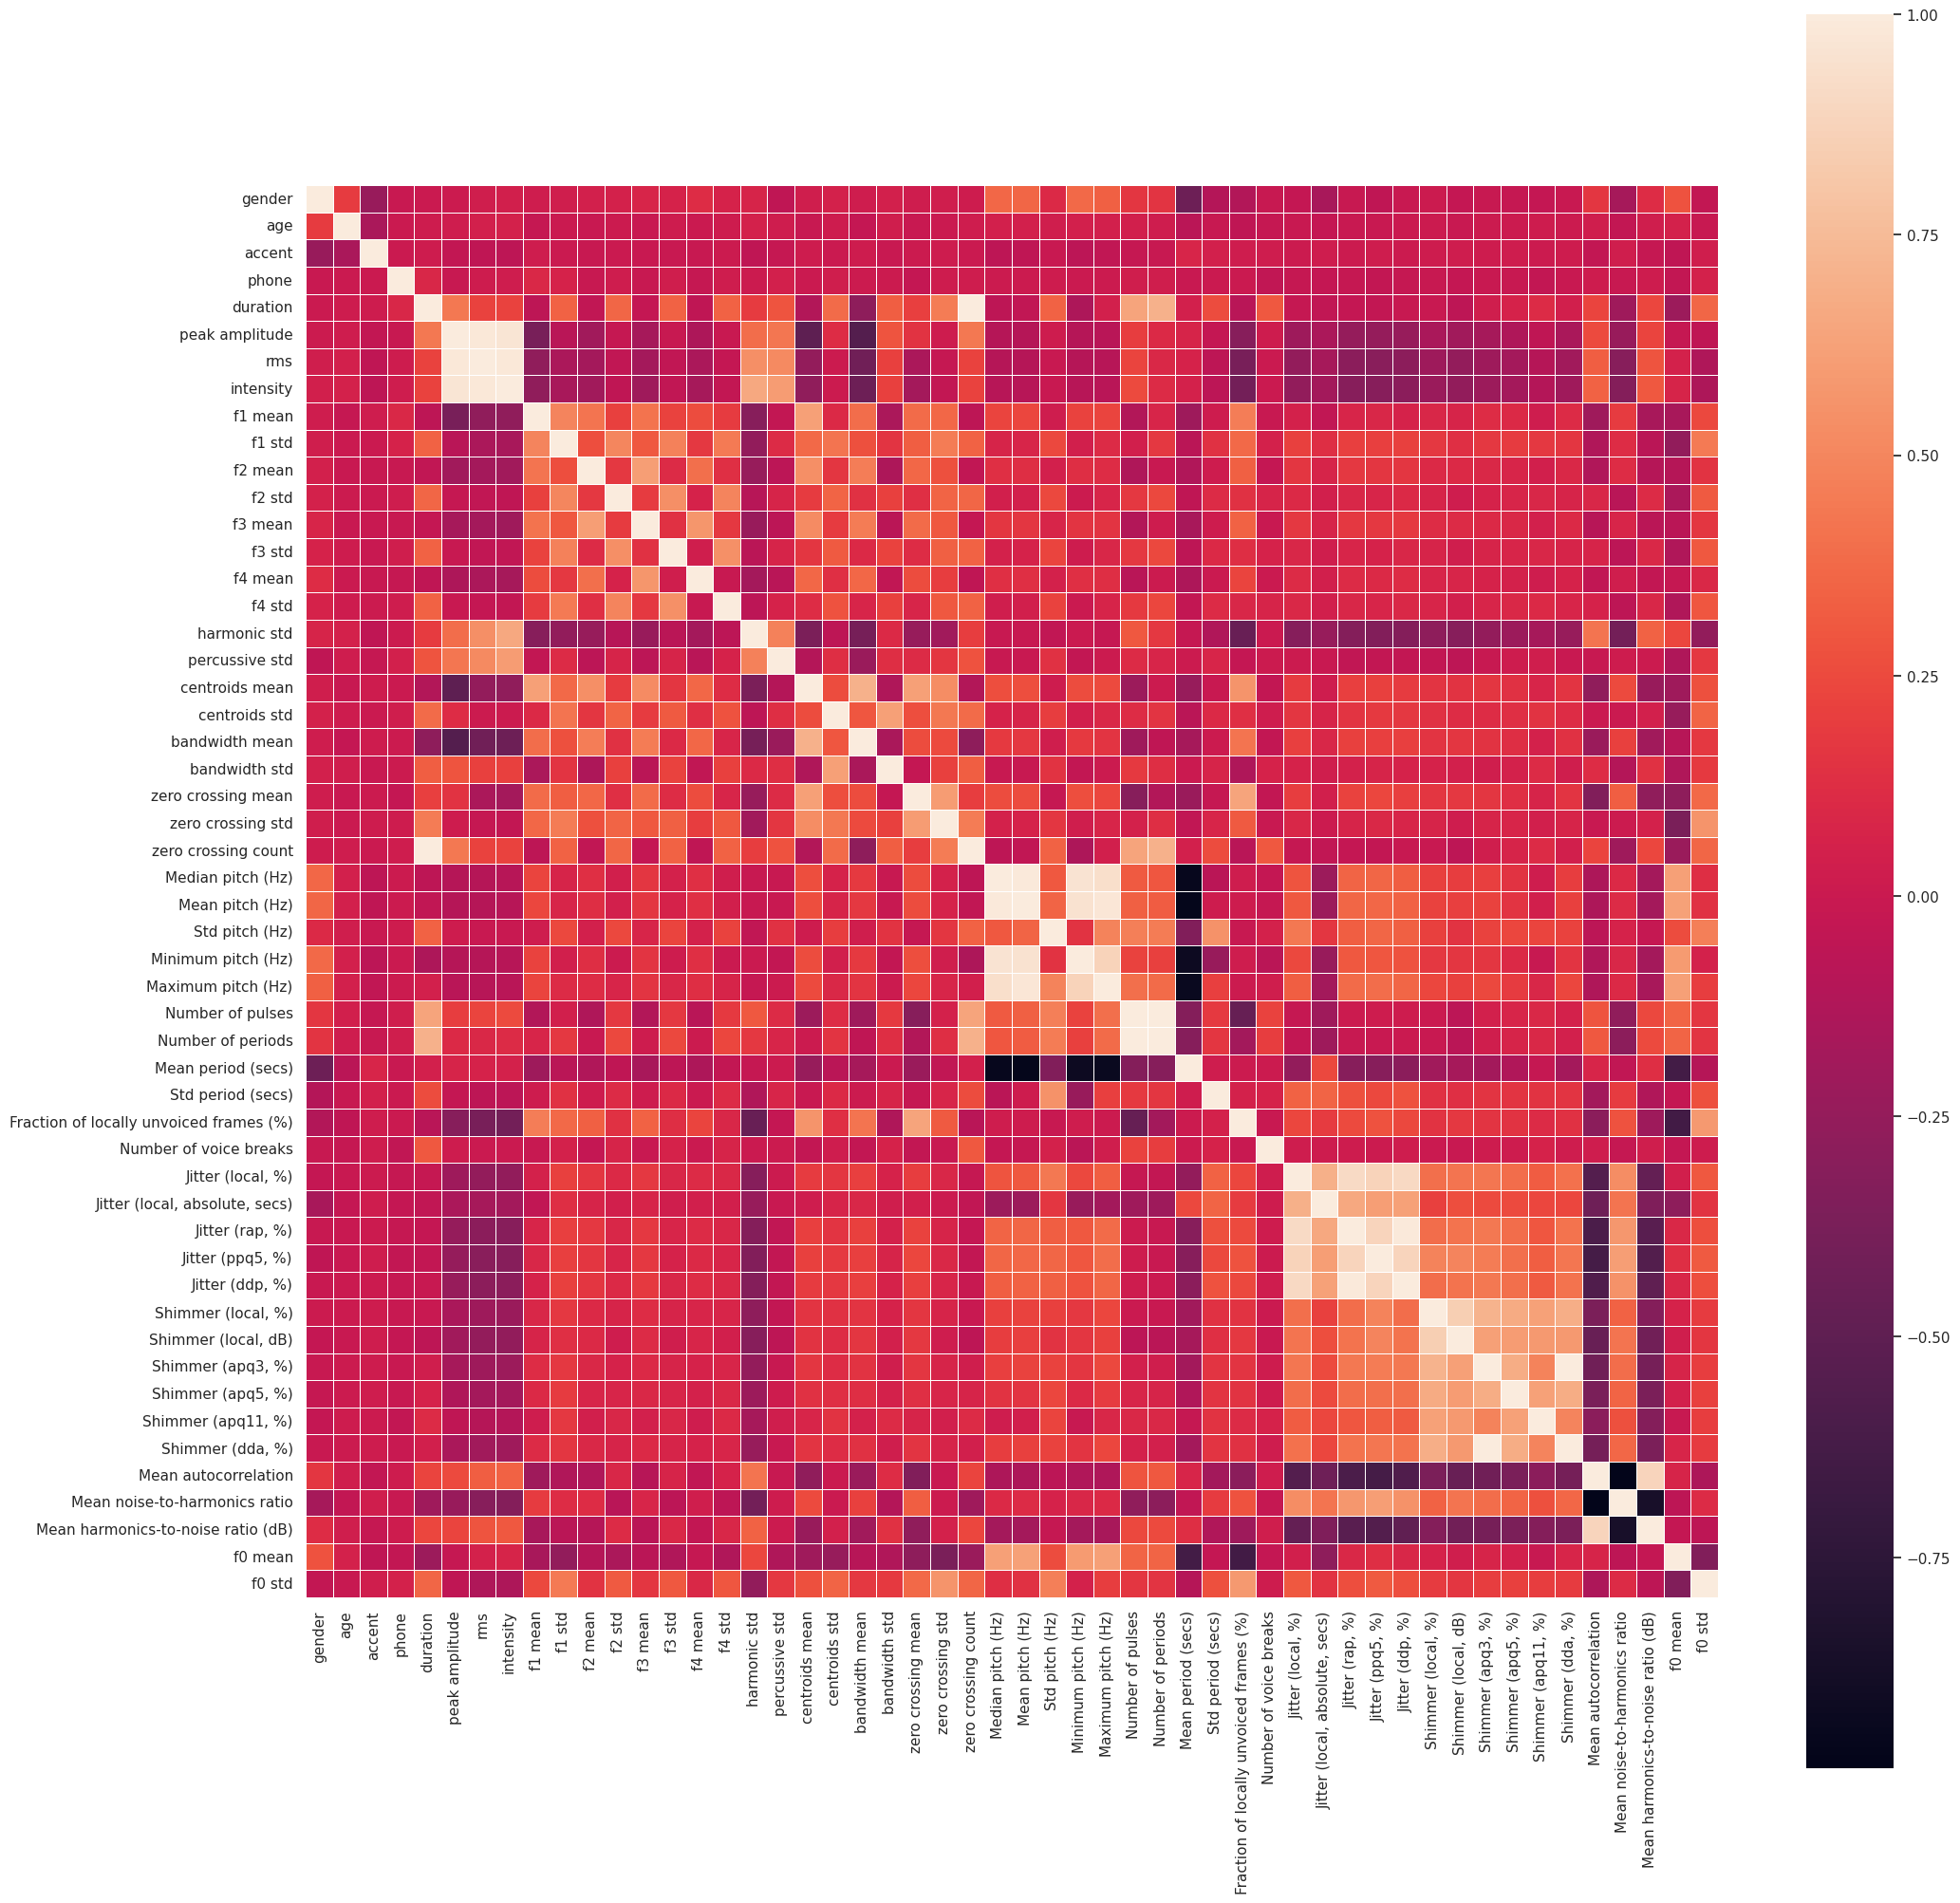

In [ ]:
plt.figure(figsize=(24,24))
correlation = df_corr.corr()
sns.heatmap(correlation, square=True, linewidth = .5)
# plt.title('pearson', fontsize=12)

## Conclusion

The above correlation map illustrates the interaction between different acoustic features. When deciding on features for extraction and engineering, it would be necessary to ensure the correlated features are considered also.

The map also shows the significant correlation of pitch features and gender. The strength of this correlation is also reflected in the pairwise test results. Following gender, age and accent features can alos be considered. Any feature representation used for training should be able to encode or adapt to/from these differentiable features in order to make models more robust.